# Simple RNN

We create a simple RNN here - trying to predict a known sequence. <br>
<i>This is from Udacity's RNN exercise</i>

In [1]:
import torch
from torch import nn

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Show the Sequence

Create and plot the sequence we want to predict using RNN

In [2]:
plt.figure(figsize = (8,5))

seq_length = 20

time_steps = np.linspace(0, np.pi, seq_length + 1)
data = np.sin(time_steps)
data

array([0.00000000e+00, 1.56434465e-01, 3.09016994e-01, 4.53990500e-01,
       5.87785252e-01, 7.07106781e-01, 8.09016994e-01, 8.91006524e-01,
       9.51056516e-01, 9.87688341e-01, 1.00000000e+00, 9.87688341e-01,
       9.51056516e-01, 8.91006524e-01, 8.09016994e-01, 7.07106781e-01,
       5.87785252e-01, 4.53990500e-01, 3.09016994e-01, 1.56434465e-01,
       1.22464680e-16])

<Figure size 576x360 with 0 Axes>

In [3]:
data.shape

(21,)

In [4]:
data = data.reshape(data.shape[0], 1)
data.shape

(21, 1)

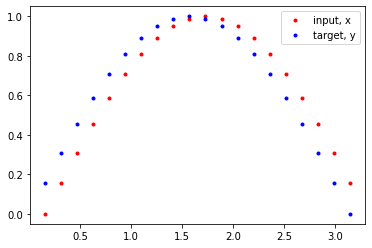

In [5]:
x = data[:-1]
y = data[1:]

# display the data
plt.plot(time_steps[1:], x, 'r.', label='input, x') # x
plt.plot(time_steps[1:], y, 'b.', label='target, y') # y

plt.legend(loc='best')
plt.show()

In [6]:
print(time_steps)

print(time_steps.shape)

[0.         0.15707963 0.31415927 0.4712389  0.62831853 0.78539816
 0.9424778  1.09955743 1.25663706 1.41371669 1.57079633 1.72787596
 1.88495559 2.04203522 2.19911486 2.35619449 2.51327412 2.67035376
 2.82743339 2.98451302 3.14159265]
(21,)


## Define RNN

Architecture: RNN followed by a fully connected neural network

input_size: size of input <br>
output_size: Size of output of the entire model, that is, output from the last fully connected layer <br>
hidden_dim: Size of the output from RNN part of the model <br>
n_layers: Number of layers in RNN part of the model <br>

In [7]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()
        
        self.hidden_dim = hidden_dim
        
        self.rnn = nn.RNN(input_size=input_size, hidden_size = hidden_dim, num_layers=n_layers, 
                          batch_first= True)
        self.fc = nn.Linear(hidden_dim, output_size)
        
    def forward(self, x, hidden):
        """
        x is input of dimension (batch_size, sequence length, feature/input size)
        hidden is initial hidden state
        """
        batch_size = x.size(0)
        r_out, hidden = self.rnn(x, hidden)
        r_out = r_out.view(-1, self.hidden_dim)
        output = self.fc(r_out)
        return output, hidden

### Check / Test the Output and Input Dimension Correctness

In [8]:
test_rnn = RNN(input_size=1, output_size=1, hidden_dim=10, n_layers=2)

# generate test data
time_steps = np.linspace(0, np.pi, seq_length)
data = np.sin(time_steps)
data = data.reshape(-1,1)
data.shape

(20, 1)

In [9]:
test_data = torch.Tensor(data).unsqueeze(0)
test_data.shape

torch.Size([1, 20, 1])

### Test Callable Objects in Python

In [10]:
class TestClass:
    def __init__(self, a):
        self.a = a
        
    def doSomething(self, b):
        print("Executing doSomething with parameter: ", b)
        
    def __call__(self, b):
        self.doSomething(b)

t = TestClass(5)

In [11]:
t(6)

Executing doSomething with parameter:  6


## Run the Neural Network

In [12]:
# test the rnn
test_rnn

RNN(
  (rnn): RNN(1, 10, num_layers=2, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [13]:
test_out, test_hidden = test_rnn(test_data, None)
print("Model Output size: ", test_out.size())
print("RNN hidden size: ", test_hidden.size())

Model Output size:  torch.Size([20, 1])
RNN hidden size:  torch.Size([2, 1, 10])


## Train the RNN

In [14]:
#Hyper-paramters
input_size = 1
output_size = 1
hidden_dim = 5
n_layers = 2

#instantiate RNN
rnn = RNN(input_size, output_size, hidden_dim, n_layers)
print(rnn)

RNN(
  (rnn): RNN(1, 5, num_layers=2, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)


In [15]:
# Loss function
criterion=nn.MSELoss()
# optimizer = torch.optim.Adam(rnn.parameters(), lr=0.1)

In [16]:
def train(rnn, n_steps, print_every, lrate, show_graph):
    
    # initialize the hidden state
    hidden = None
    
    optimizer = torch.optim.Adam(rnn.parameters(), lr=lrate)
    
    for batch_i, step in enumerate(range(n_steps)):
        # defining the training data 
        time_steps = np.linspace(step * np.pi, (step+1)*np.pi, seq_length + 1)
        data = np.sin(time_steps)
        data.resize((seq_length + 1, 1)) # input_size=1

        x = data[:-1]
        y = data[1:]
        
        # convert data into Tensors
        x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
        y_tensor = torch.Tensor(y)

        # outputs from the rnn
        prediction, hidden = rnn(x_tensor, hidden)

        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = hidden.data

        # calculate the loss
        loss = criterion(prediction, y_tensor)
        # zero gradients
        optimizer.zero_grad()
        # perform backprop and update weights
        loss.backward()
#         loss.backward(retain_graph = True)
        optimizer.step()

        # display loss and predictions

        if batch_i%print_every == 0:        
            print('Loss: ', loss.item())
            if show_graph:
                plt.plot(time_steps[1:], x, 'r.') # input
                plt.plot(time_steps[1:], prediction.data.numpy().flatten(), 'b.') # predictions
                plt.show()
    
    return rnn, loss.item()      
        
        
# def define_training_data(step):
#     time_steps = np.linspace(step*np.pi, (step + 1) *np.pi, seq_length+1)
#     data = np.sin(time_steps)
#     data = data.reshape(-1, 1)
#     x = data[:-1]
#     y = data[1:]
    
#     x_tensor = torch.Tensor(x).unsqueeze(0)
#     y_tensor = torch.Tensor(y)
    
#     return x,y,x_tensor, y_tensor, time_steps

============hidden dimension: 1 ==========
Loss:  0.027214398607611656


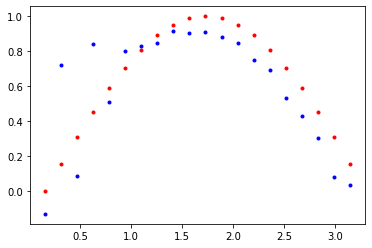

Loss:  0.03586825728416443


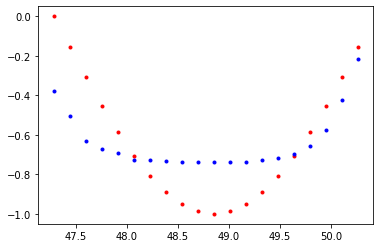

Loss:  0.01226052176207304


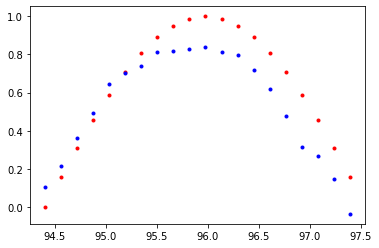

Loss:  0.0006667485577054322


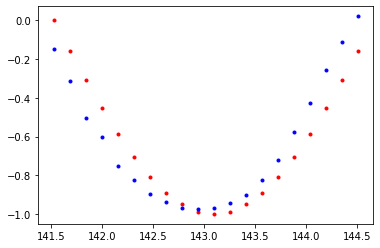

Loss:  0.0009866831824183464


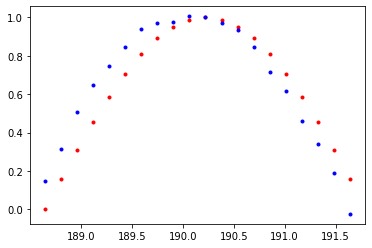

Loss:  0.00036272546276450157


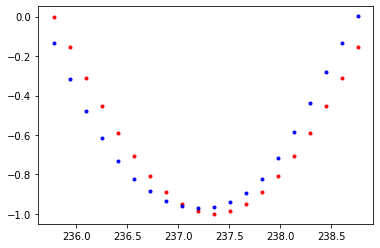

Loss:  0.0002162187302019447


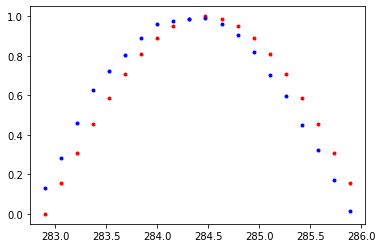

Loss:  0.0002559044223744422


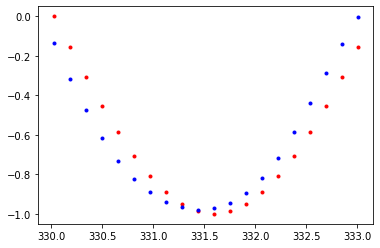

Loss:  0.00011102869757451117


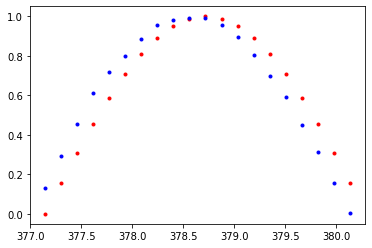

Loss:  0.00018302505486644804


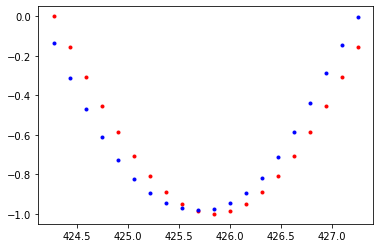

Loss:  6.206794932950288e-05


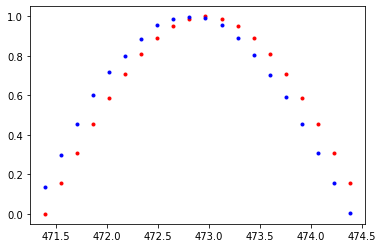

Loss:  0.00012297627108637244


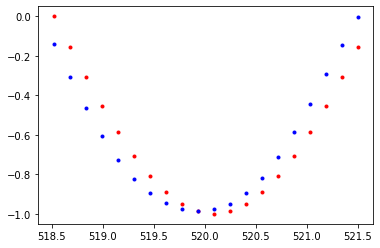

Loss:  3.624903183663264e-05


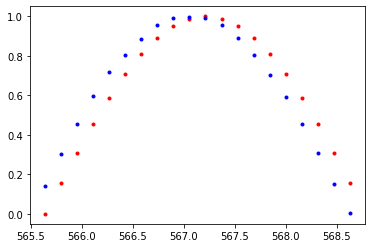

Loss:  7.878268661443144e-05


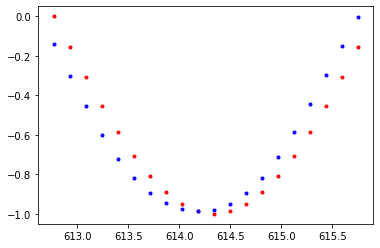

Loss:  6.14965902059339e-05


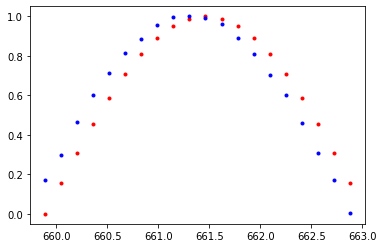

Loss:  0.020292796194553375


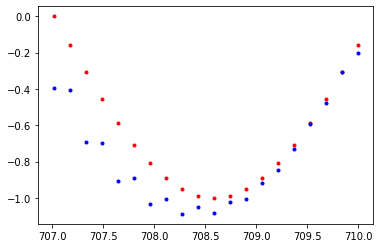

Loss:  0.001639322959817946


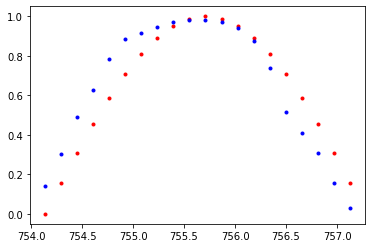

Loss:  0.0002818706852849573


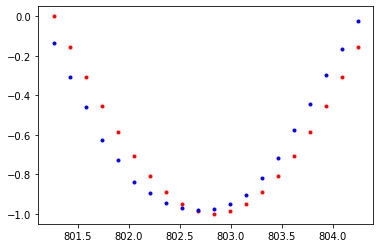

Loss:  0.00032744891359470785


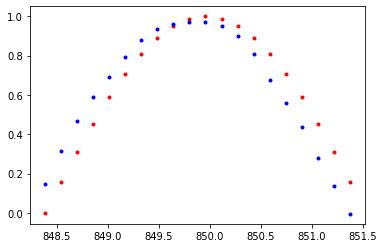

Loss:  0.00012723900726996362


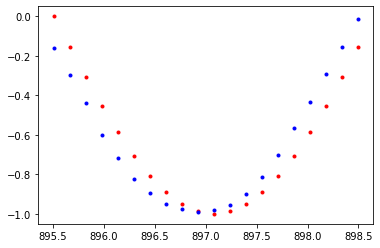

Loss:  0.00010852266132133082


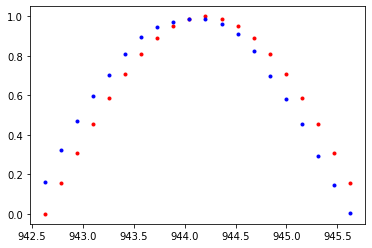

Loss:  4.931560761178844e-05


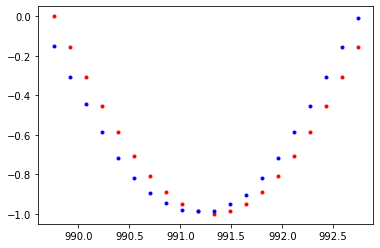

Loss:  0.010237248614430428


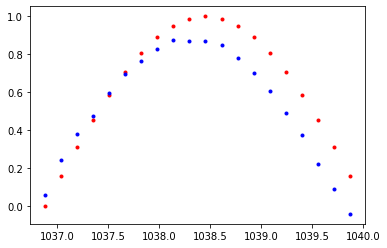

Loss:  0.0015183057403191924


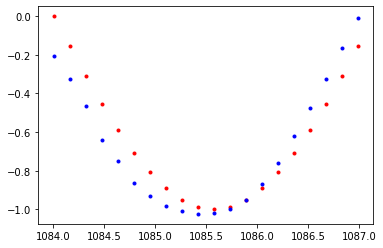

Loss:  0.0006887922645546496


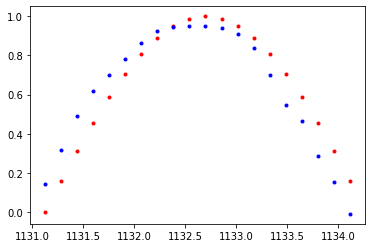

Loss:  7.877286407165229e-05


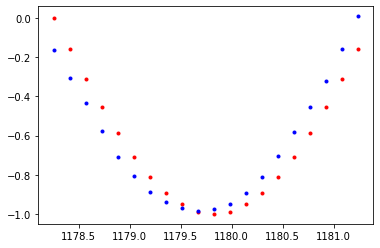

Loss:  0.00010298544657416642


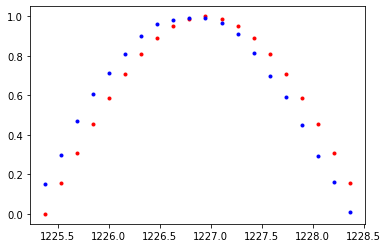

Loss:  3.23467975249514e-05


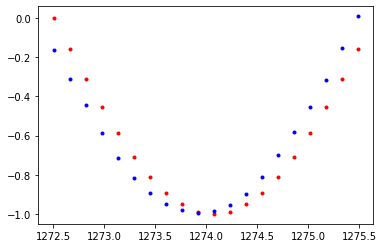

Loss:  6.724669219693169e-05


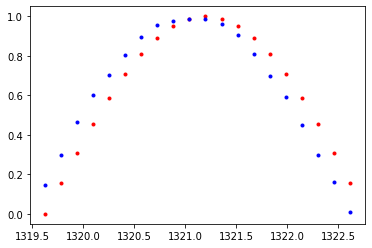

Loss:  2.5567760530975647e-05


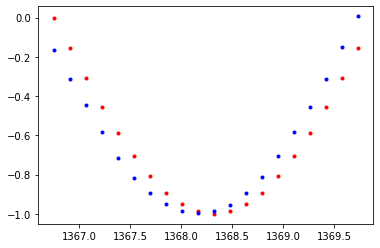

Loss:  6.216196925379336e-05


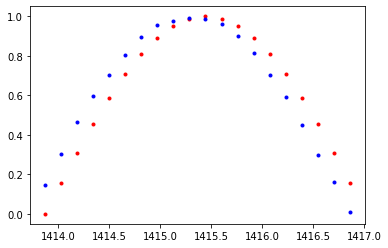

Loss:  1.8494667529012077e-05


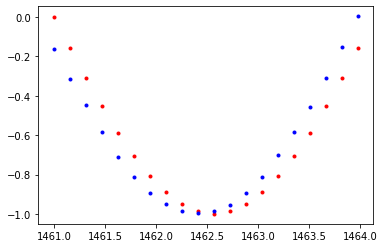

Loss:  5.781864092568867e-05


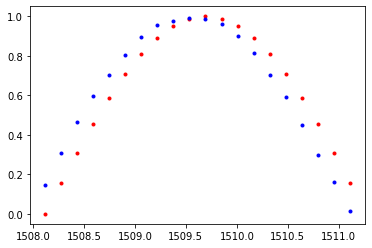

Loss:  1.3434636457532179e-05


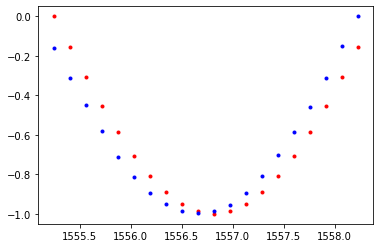

Loss:  6.718681106576696e-05


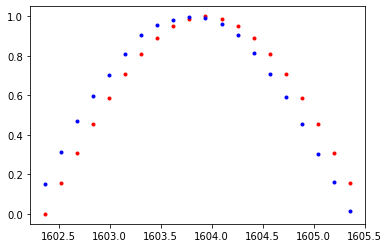

Loss:  0.021580254659056664


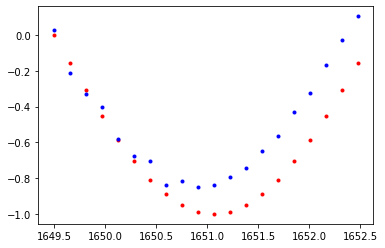

Loss:  0.002794870873913169


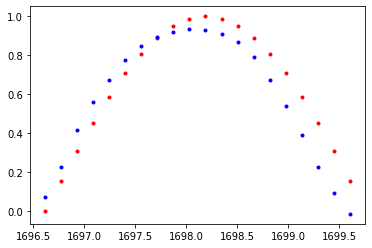

Loss:  0.0007854572613723576


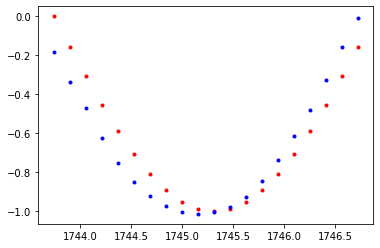

Loss:  0.0009010484209284186


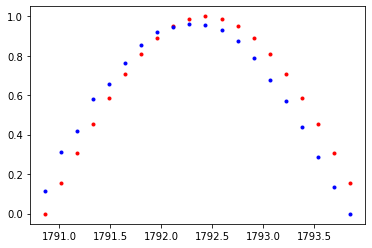

Loss:  0.0003766994341276586


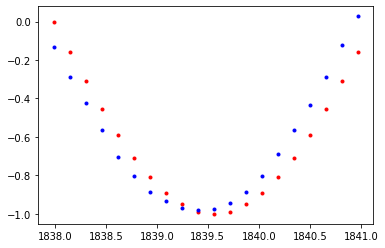

Loss:  0.00019290427735541016


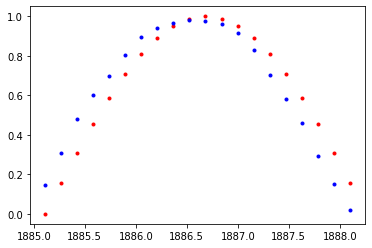

Loss:  5.037253140471876e-05


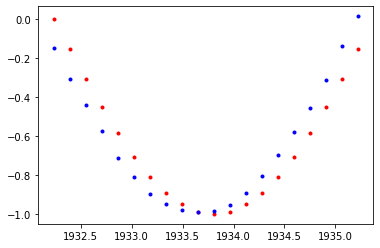

Loss:  9.592742571840063e-05


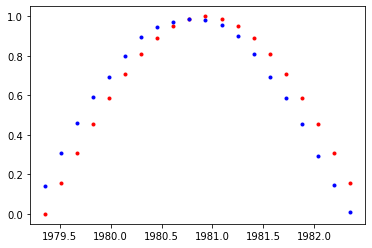

Loss:  4.726805127575062e-05


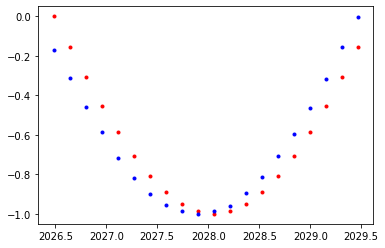

Loss:  0.0018369966419413686


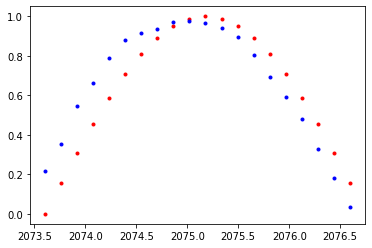

Loss:  0.0013435560977086425


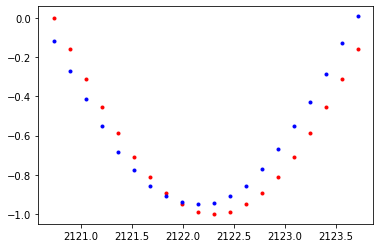

Loss:  0.00044321277528069913


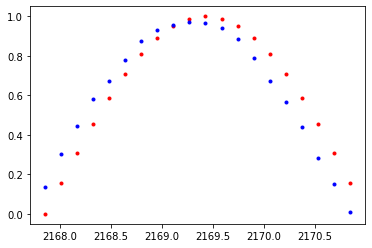

Loss:  0.00018361448019277304


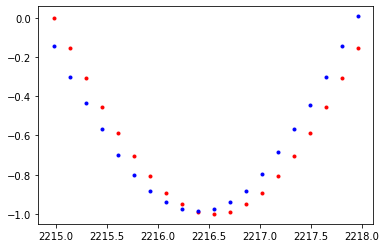

Loss:  6.662384839728475e-05


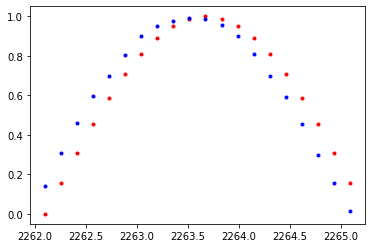

Loss:  0.00022844444902148098


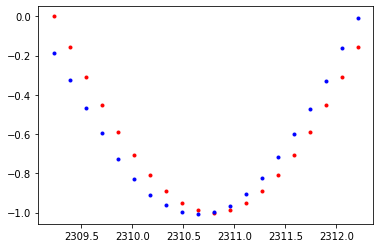

Loss:  0.0010114767355844378


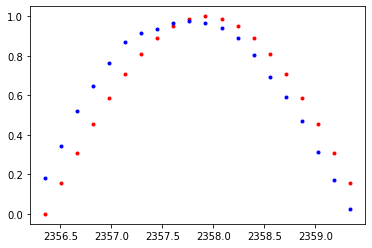

Loss:  0.00039209311944432557


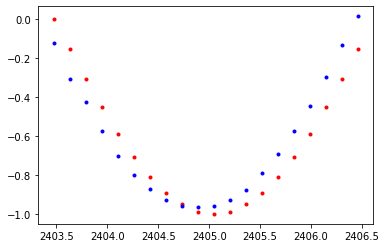

Loss:  9.092495747609064e-05


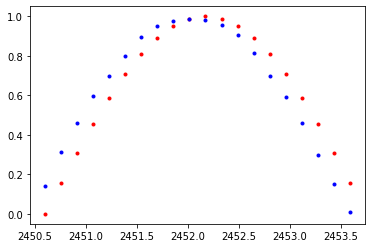

Loss:  0.00025298207765445113


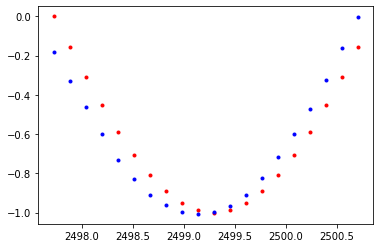

Loss:  0.001611539744772017


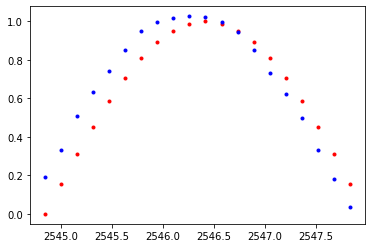

Loss:  4.851437915931456e-05


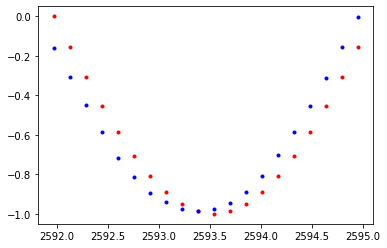

Loss:  0.001232196344062686


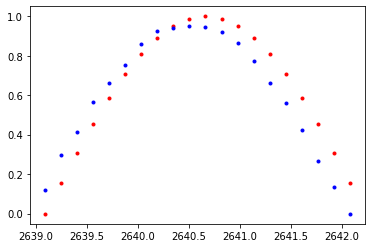

Loss:  0.0006594606093131006


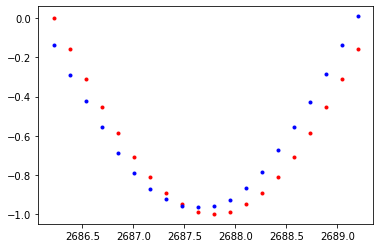

Loss:  0.0008699006866663694


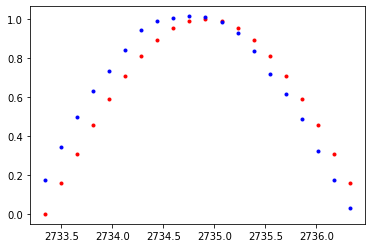

Loss:  0.001185569679364562


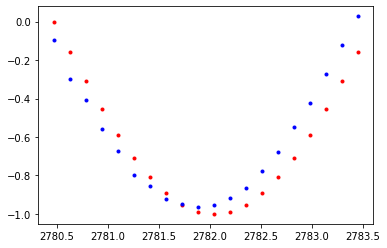

Loss:  0.00017887343710754067


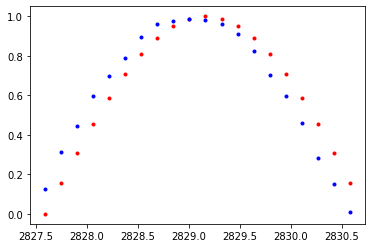

Loss:  0.0005211752140894532


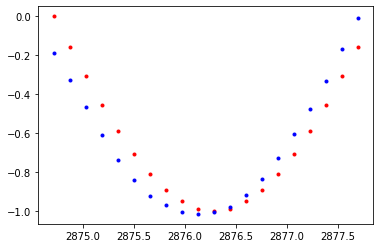

Loss:  0.0011640108423307538


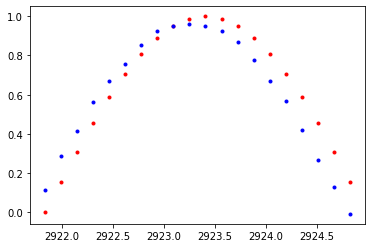

Loss:  0.0017548742471262813


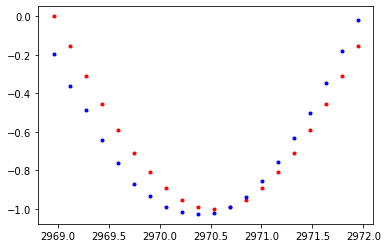

Loss:  0.00011585273750824854


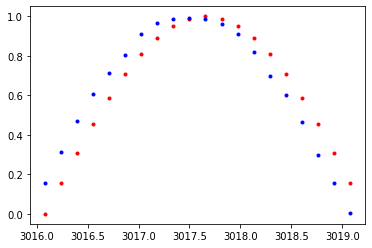

Loss:  0.0021158854942768812


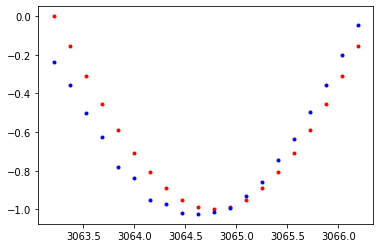

Loss:  0.0009238589555025101


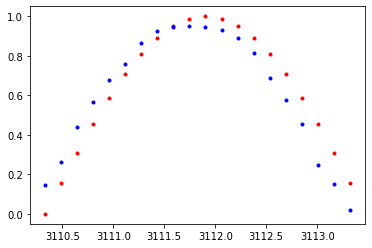

============hidden dimension: 6 ==========
Loss:  0.010956048965454102


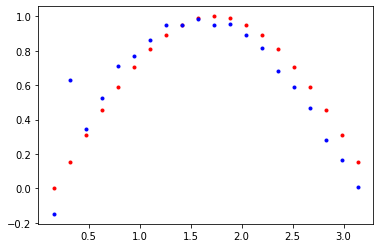

Loss:  0.011413238011300564


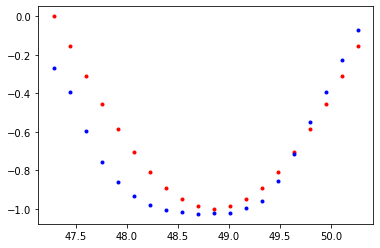

Loss:  0.0009253137395717204


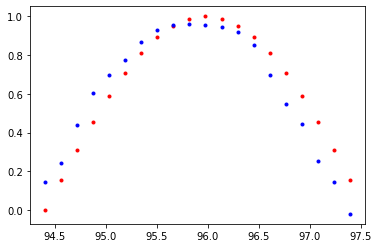

Loss:  0.0009215218597091734


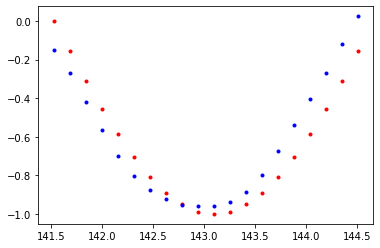

Loss:  0.0001679085980867967


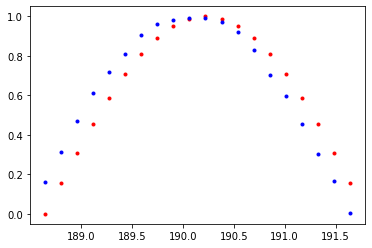

Loss:  9.146036609308794e-05


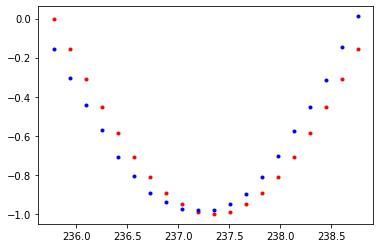

Loss:  7.428838580381125e-05


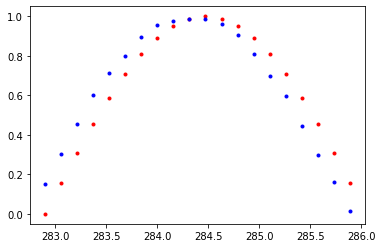

Loss:  4.4432566937757656e-05


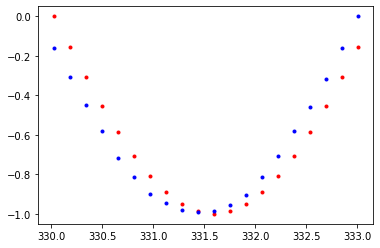

Loss:  5.6152610341086984e-05


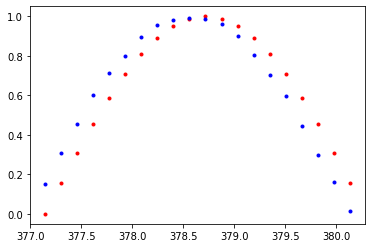

Loss:  3.2558153179707006e-05


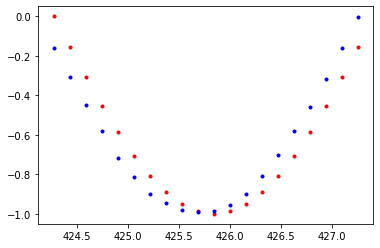

Loss:  4.781290044775233e-05


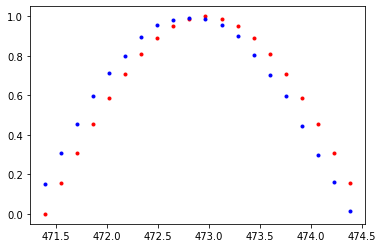

Loss:  2.510505510144867e-05


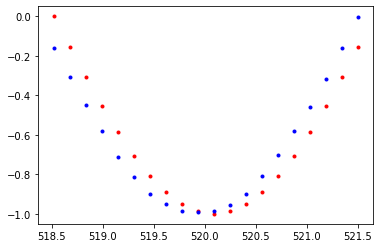

Loss:  4.398401142680086e-05


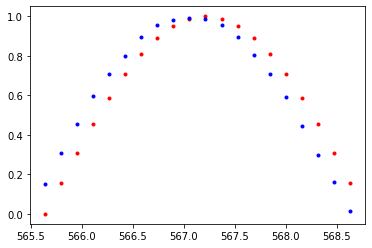

Loss:  2.0174544260953553e-05


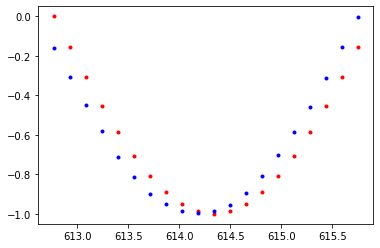

Loss:  4.6841567382216454e-05


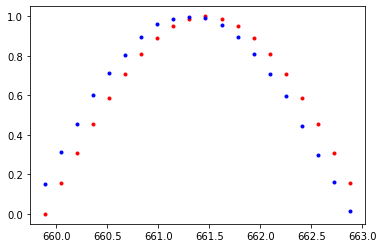

Loss:  0.002040105639025569


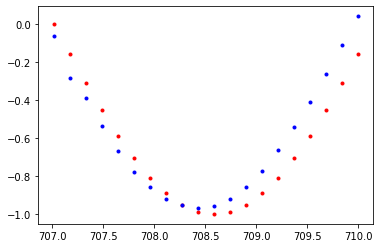

Loss:  0.00023887092538643628


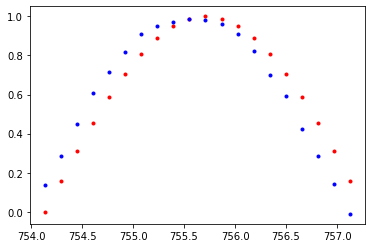

Loss:  0.00017911051691044122


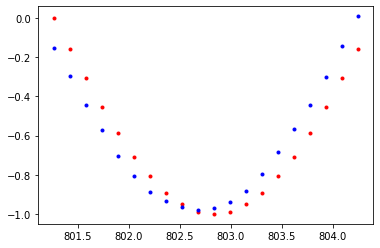

Loss:  0.00010460733756190166


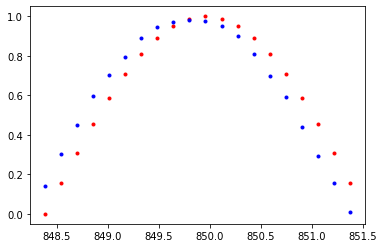

Loss:  2.3993454306037165e-05


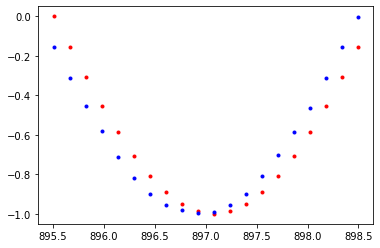

Loss:  5.691035039490089e-05


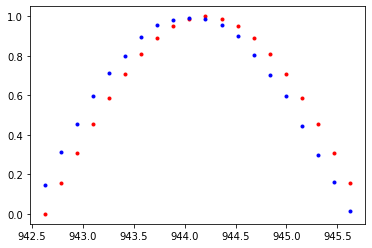

Loss:  1.5606112356181256e-05


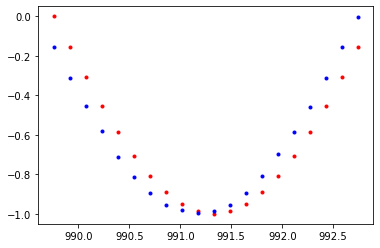

Loss:  4.6778852265561e-05


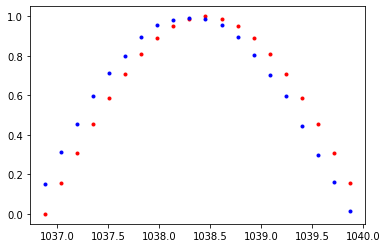

Loss:  1.2359037100395653e-05


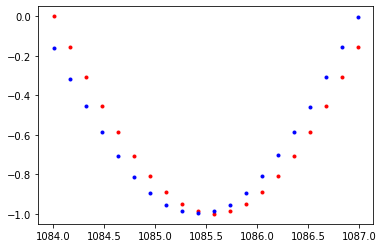

Loss:  4.2692703573266044e-05


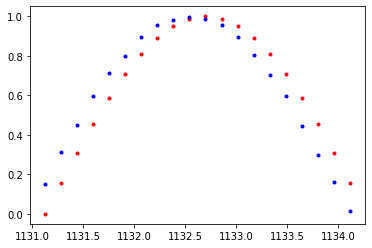

Loss:  1.2432862604327966e-05


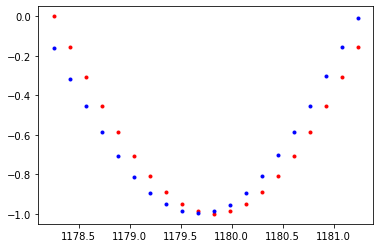

Loss:  4.132861067773774e-05


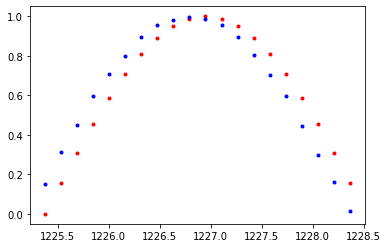

Loss:  1.4496966286969837e-05


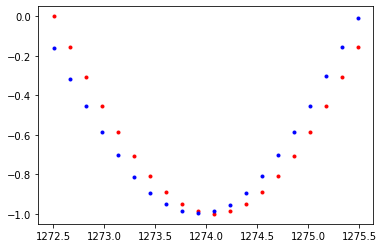

Loss:  5.324422454577871e-05


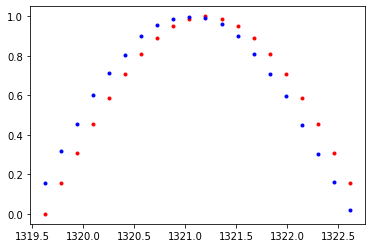

Loss:  0.009751188568770885


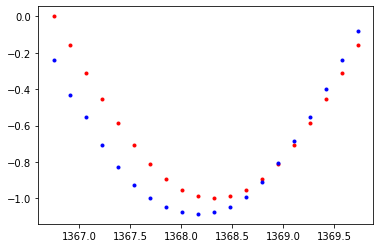

Loss:  0.0009023765451274812


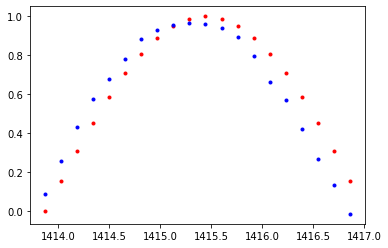

Loss:  0.00014459789963439107


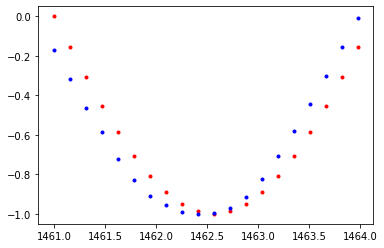

Loss:  9.640292410040274e-05


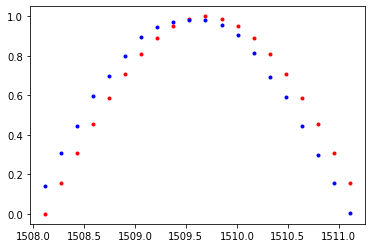

Loss:  3.801293860306032e-05


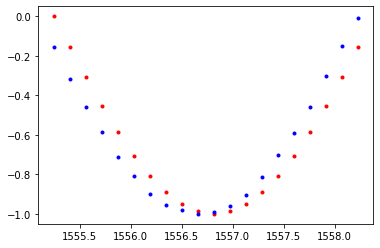

Loss:  4.7968991566449404e-05


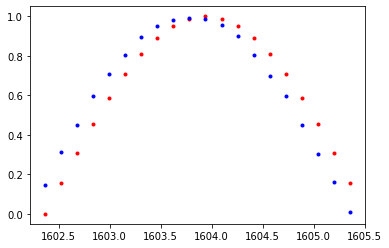

Loss:  2.756601679720916e-05


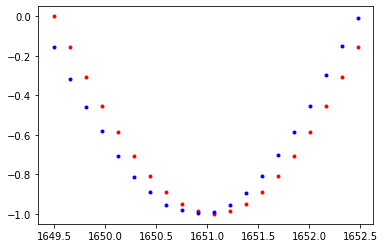

Loss:  3.889256186084822e-05


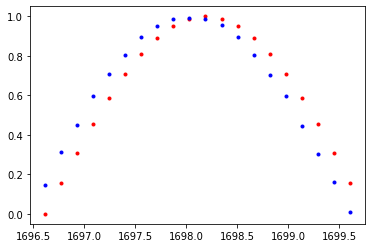

Loss:  2.551868965383619e-05


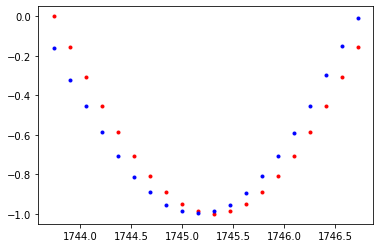

Loss:  3.879815267282538e-05


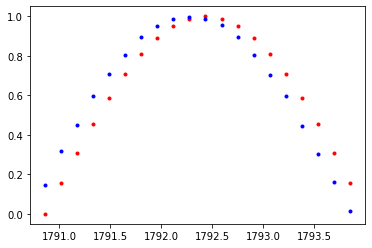

Loss:  2.595761907286942e-05


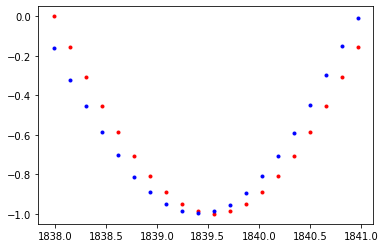

Loss:  6.259333895286545e-05


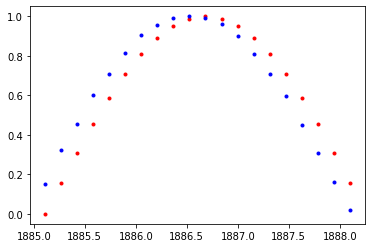

Loss:  0.002516005886718631


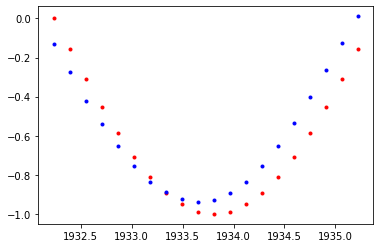

Loss:  0.0005475202342495322


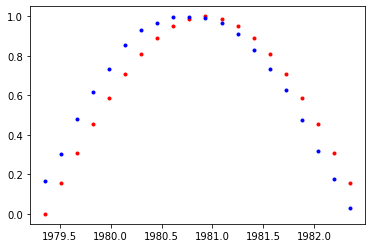

Loss:  3.931789251510054e-05


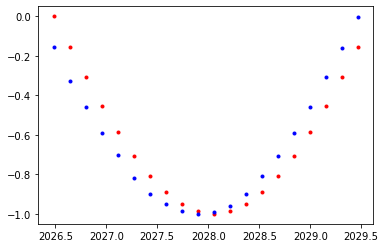

Loss:  0.00020099067478440702


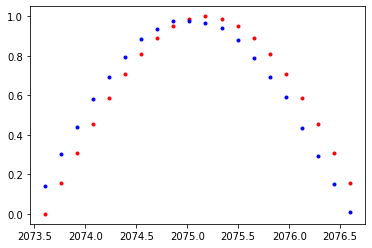

Loss:  1.8995204300154e-05


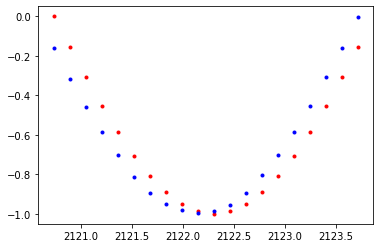

Loss:  4.5039156248094514e-05


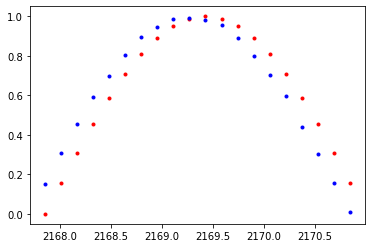

Loss:  0.00032794979051686823


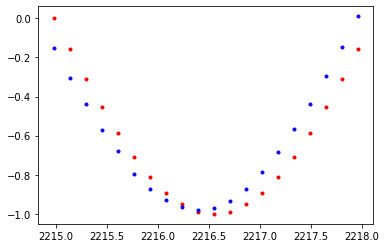

Loss:  0.0013287728652358055


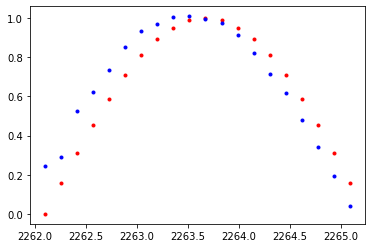

Loss:  0.000279323139693588


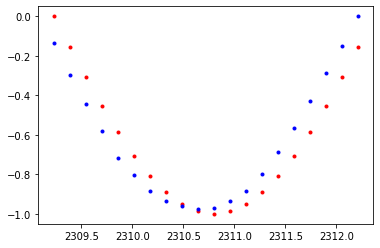

Loss:  8.061109110713005e-05


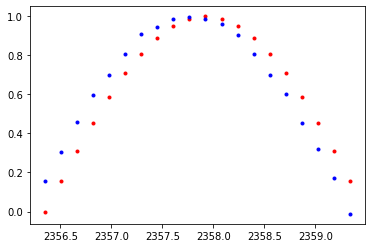

Loss:  0.00015903990424703807


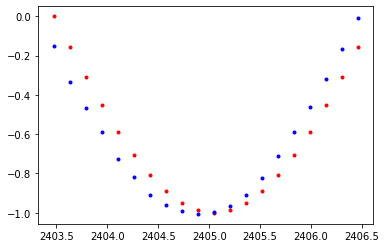

Loss:  0.004283535294234753


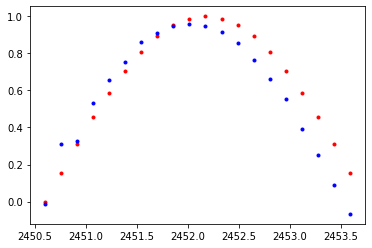

Loss:  0.000204691881663166


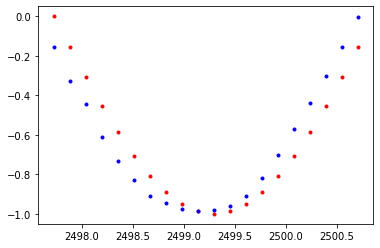

Loss:  0.000198800305952318


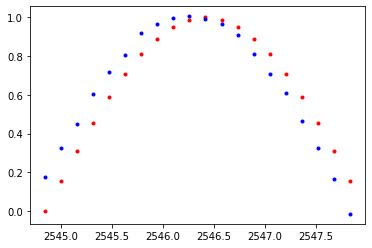

Loss:  9.734964987728745e-05


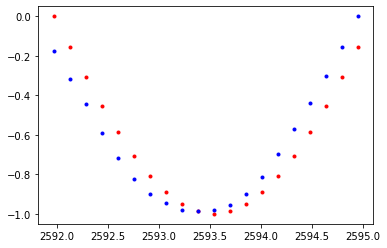

Loss:  2.9163316867197864e-05


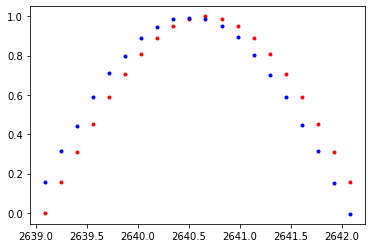

Loss:  6.242057861527428e-05


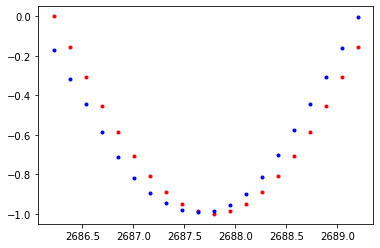

Loss:  1.9513043298502453e-05


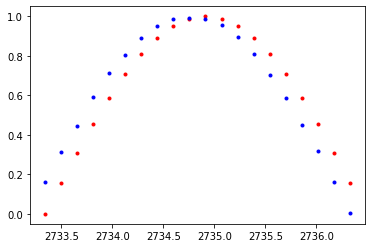

Loss:  0.00013709650374948978


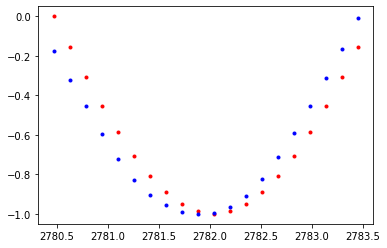

Loss:  0.006124114152044058


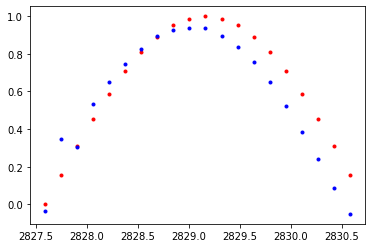

Loss:  0.0004061015497427434


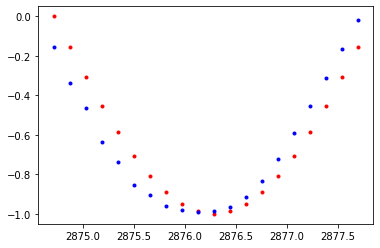

Loss:  0.00017332445713691413


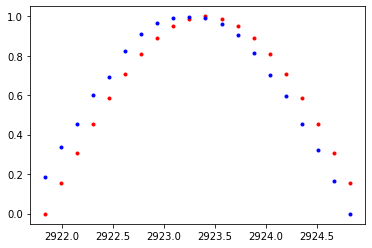

Loss:  6.853011291241273e-05


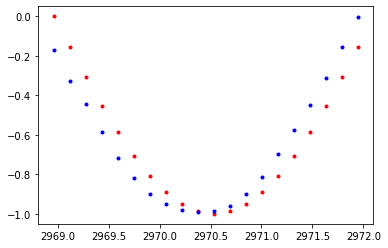

Loss:  3.5049797588726506e-05


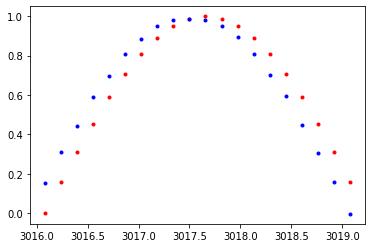

Loss:  4.235860251355916e-05


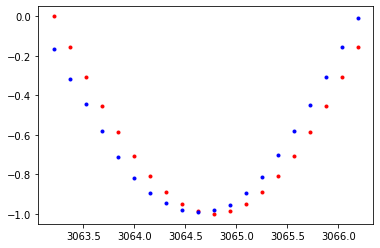

Loss:  2.86020222119987e-05


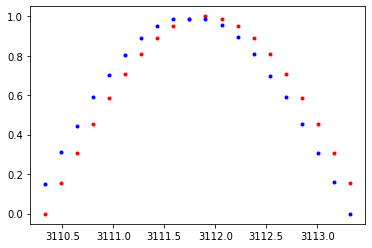

============hidden dimension: 11 ==========
Loss:  0.013063762336969376


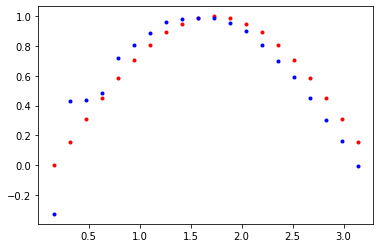

Loss:  0.01433972455561161


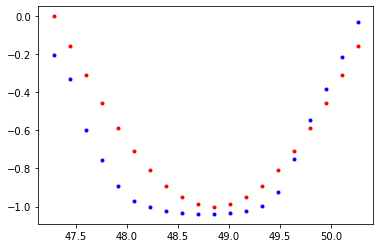

Loss:  0.0014311523409560323


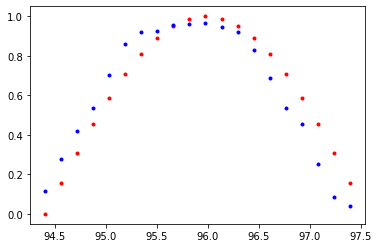

Loss:  0.0006036240956746042


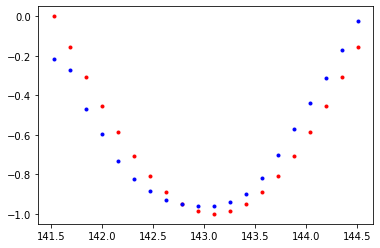

Loss:  0.00018915913824457675


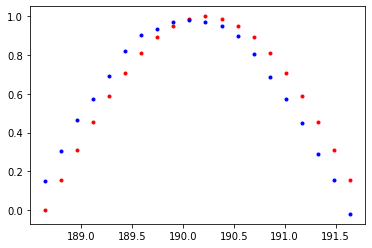

Loss:  0.0004090762522537261


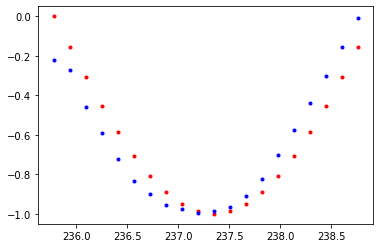

Loss:  0.0004116259515285492


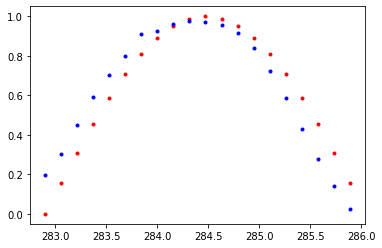

Loss:  0.00020997239334974438


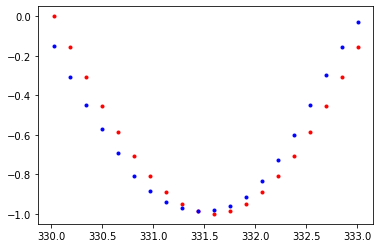

Loss:  0.00021246590767987072


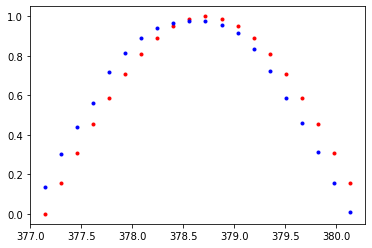

Loss:  7.0717949711252e-05


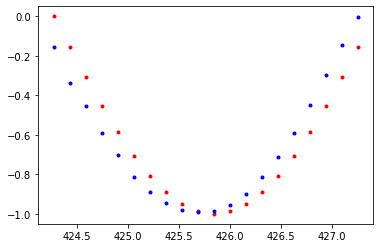

Loss:  8.595941471867263e-05


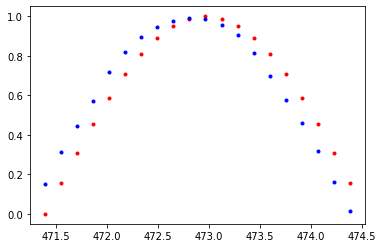

Loss:  4.661386628868058e-05


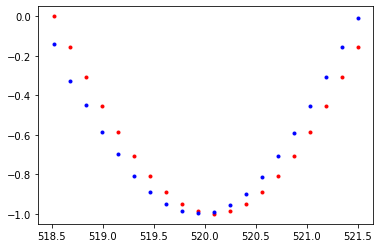

Loss:  7.402192568406463e-05


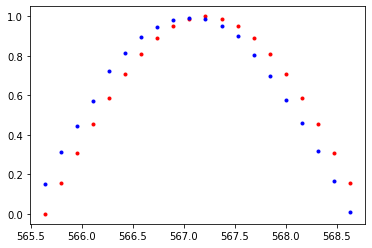

Loss:  3.520106110954657e-05


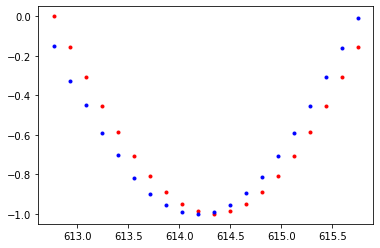

Loss:  0.00017544486036058515


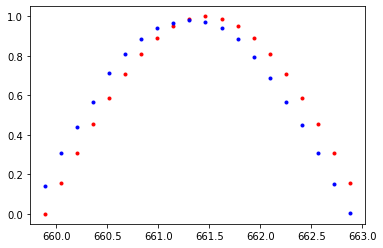

Loss:  2.9737491786363535e-05


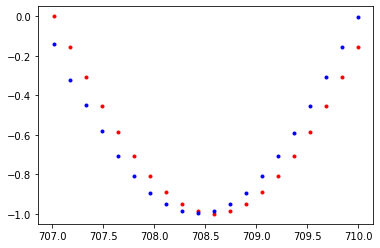

Loss:  0.0005876742652617395


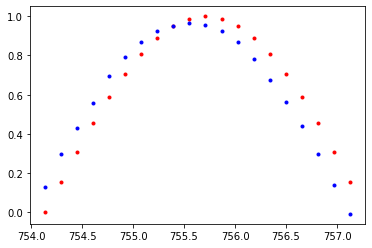

Loss:  1.3380026757658925e-05


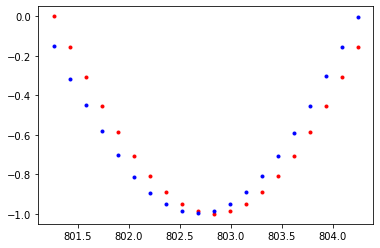

Loss:  7.163674308685586e-05


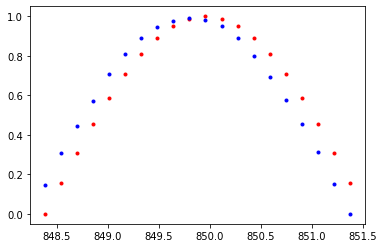

Loss:  5.158308340469375e-05


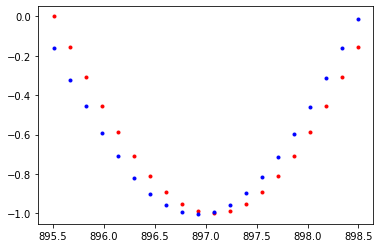

Loss:  0.0010618121596053243


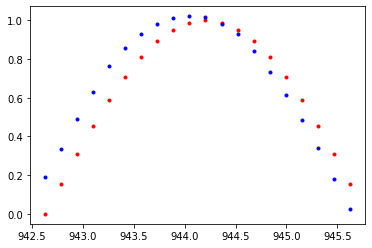

Loss:  2.3793814762029797e-05


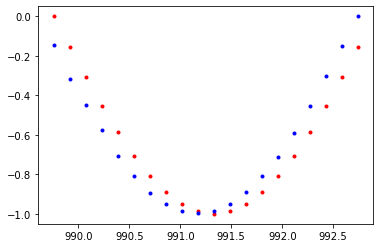

Loss:  5.166124537936412e-05


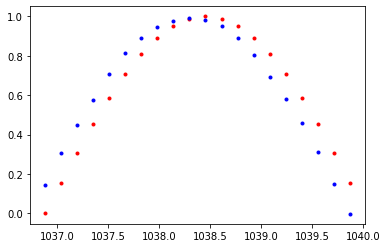

Loss:  3.646249388111755e-05


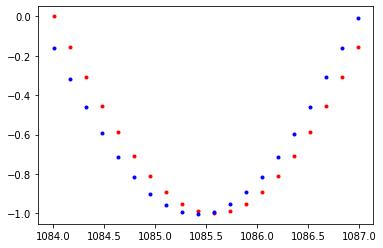

Loss:  0.000581861415412277


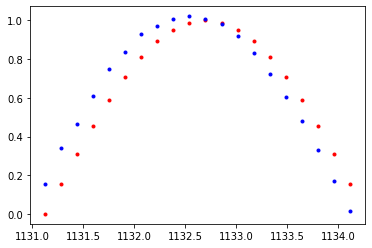

Loss:  0.0006608781986869872


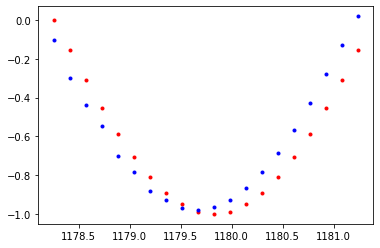

Loss:  0.000555758539121598


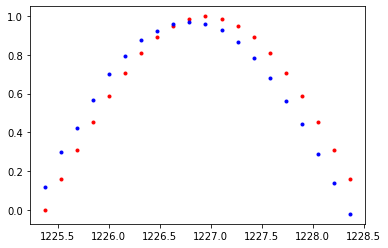

Loss:  1.0467621905263513e-05


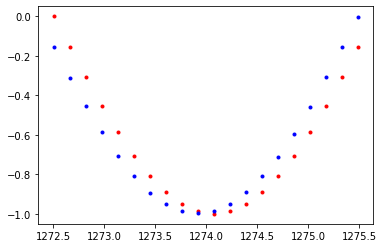

Loss:  2.522637805668637e-05


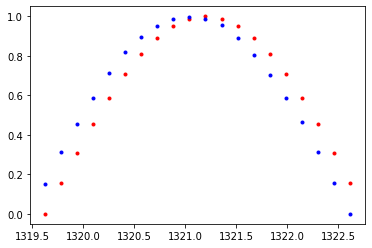

Loss:  5.4910888138692826e-05


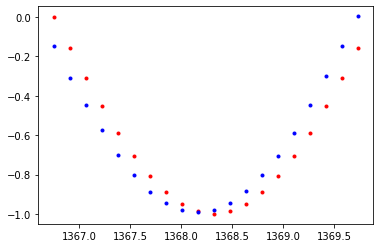

Loss:  9.370102634420618e-05


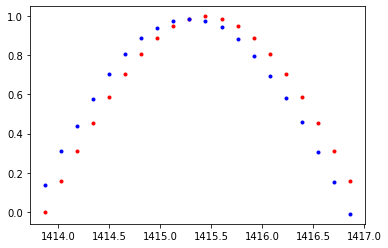

Loss:  0.0011626487830653787


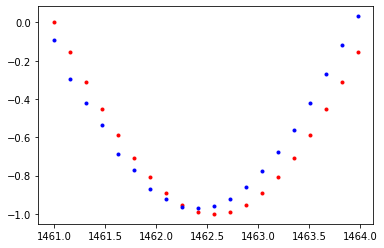

Loss:  0.00018871853535529226


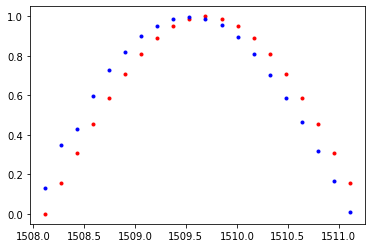

Loss:  0.00043828535126522183


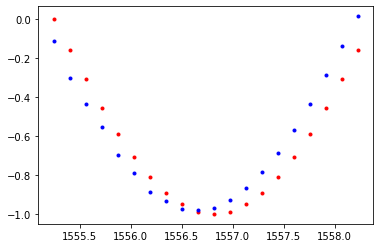

Loss:  0.0006358687533065677


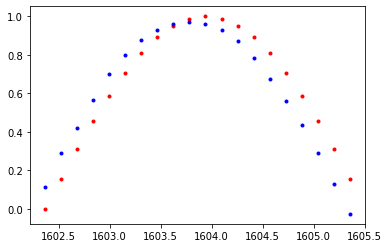

Loss:  1.0340832886868156e-05


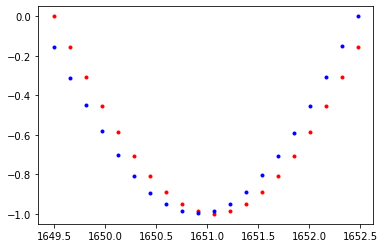

Loss:  3.533399649313651e-05


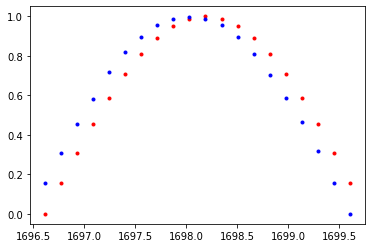

Loss:  1.1765450835810043e-05


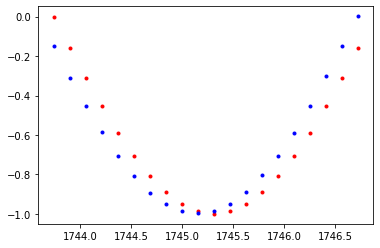

Loss:  3.746489528566599e-05


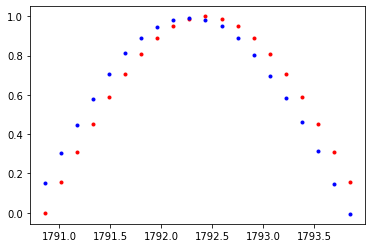

Loss:  2.4175149519578554e-05


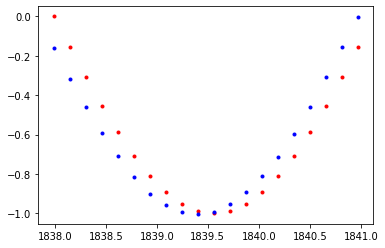

Loss:  3.5827644751407206e-05


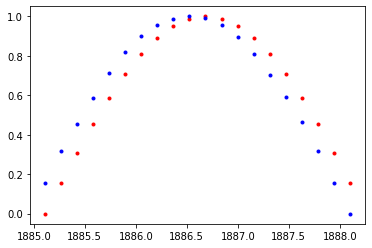

Loss:  6.206428679433884e-06


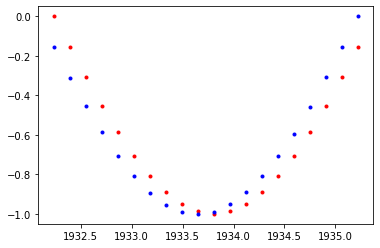

Loss:  9.900952136376873e-05


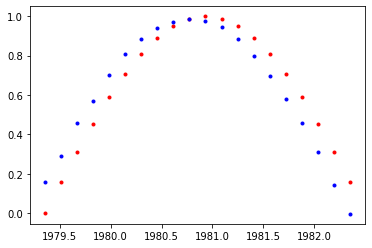

Loss:  0.00201779929921031


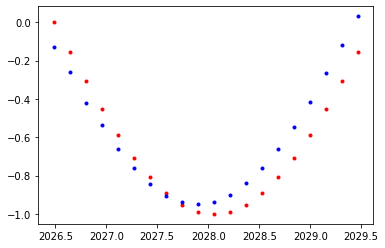

Loss:  0.00044214838999323547


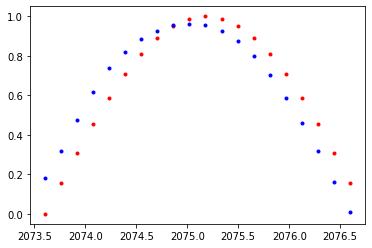

Loss:  0.000504960713442415


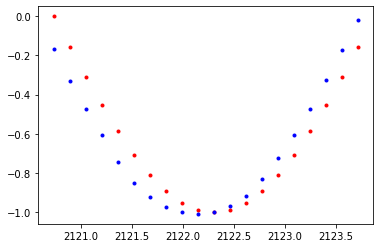

Loss:  0.00016239249089267105


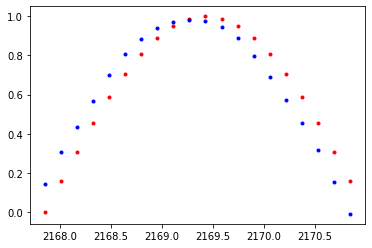

Loss:  2.7096819394500926e-05


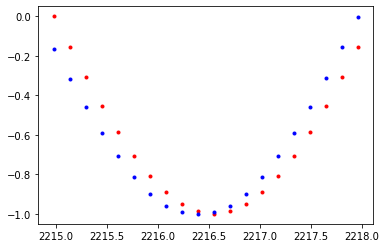

Loss:  0.0005544848390854895


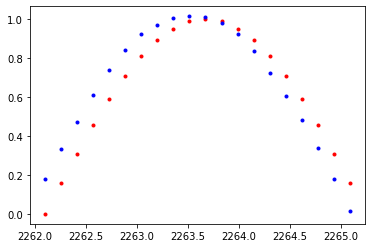

Loss:  0.0004652409697882831


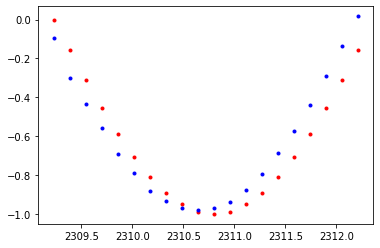

Loss:  0.000514283892698586


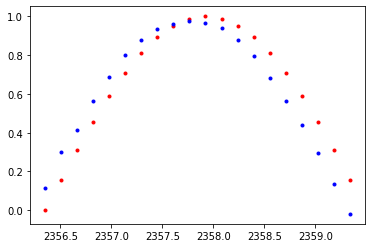

Loss:  8.785938007349614e-06


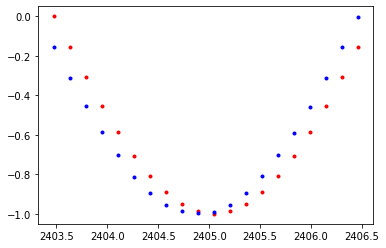

Loss:  3.476504571153782e-05


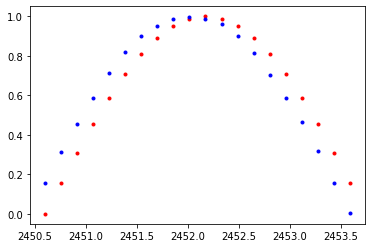

Loss:  1.1052768968511373e-05


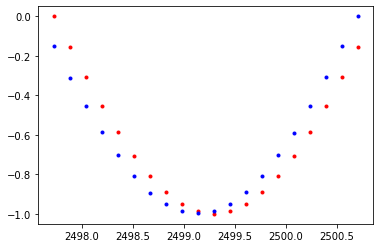

Loss:  3.989154356531799e-05


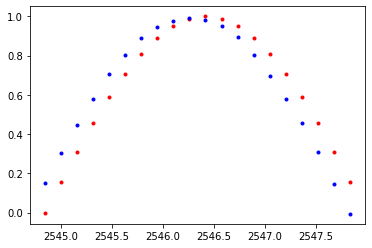

Loss:  2.4252669390989468e-05


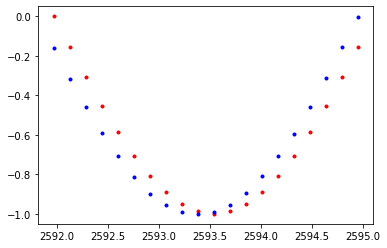

Loss:  2.5209727027686313e-05


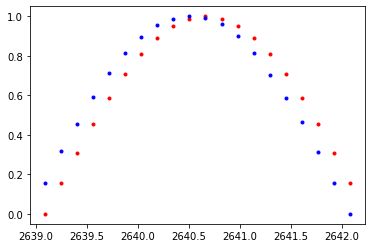

Loss:  4.6275226850411855e-06


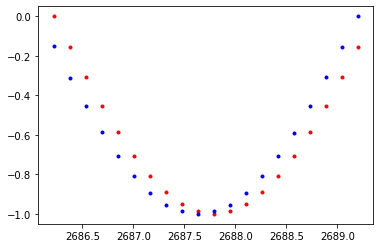

Loss:  2.515793494239915e-05


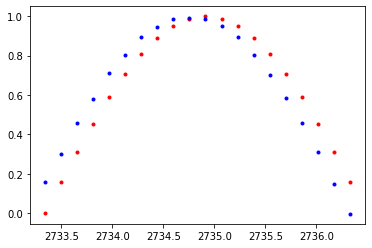

Loss:  0.00018180128245148808


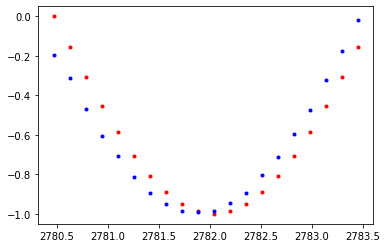

Loss:  0.0029290420934557915


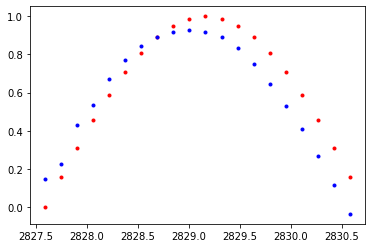

Loss:  0.00045551007497124374


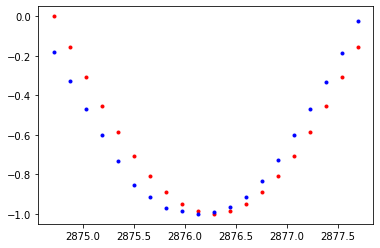

Loss:  6.317836232483387e-05


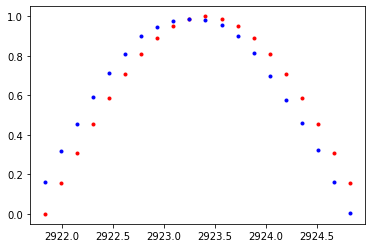

Loss:  1.8546797946328297e-05


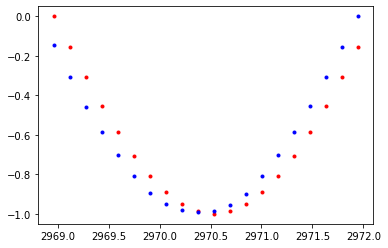

Loss:  0.00029621977591887116


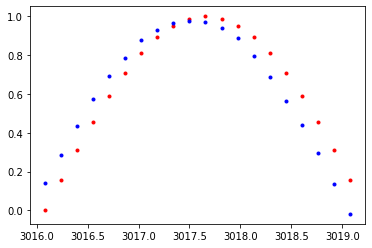

Loss:  0.0007695545209571719


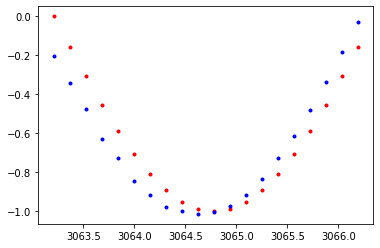

Loss:  0.0009623532532714307


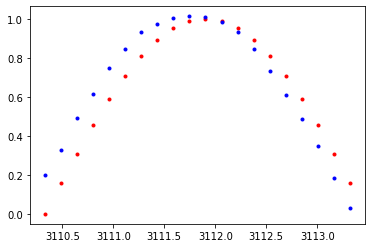

============hidden dimension: 16 ==========
Loss:  0.002358758822083473


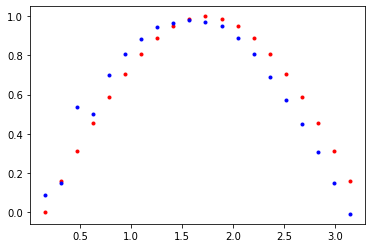

Loss:  2.570643846411258e-05


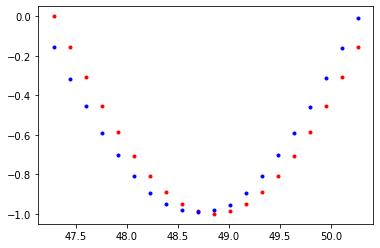

Loss:  4.1112751205218956e-05


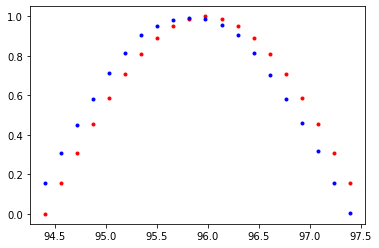

Loss:  1.3864119864592794e-05


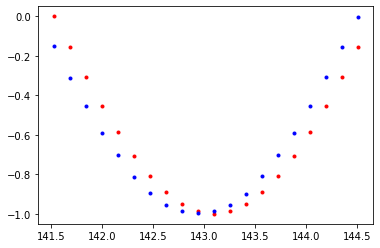

Loss:  3.4998698538402095e-05


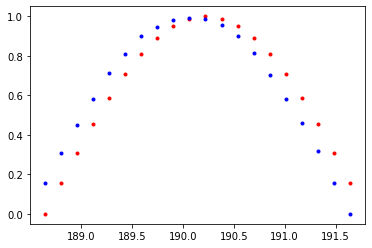

Loss:  1.2062401765433606e-05


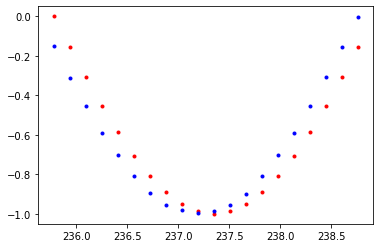

Loss:  3.0726947443326935e-05


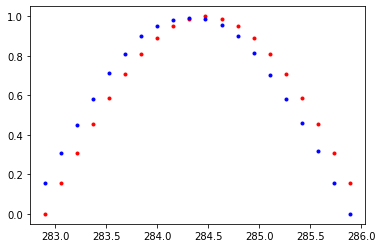

Loss:  1.0454267794557381e-05


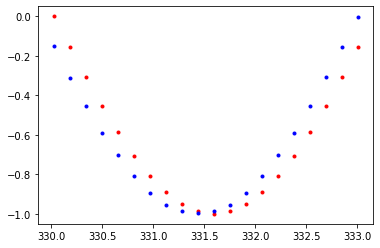

Loss:  2.6989509933628142e-05


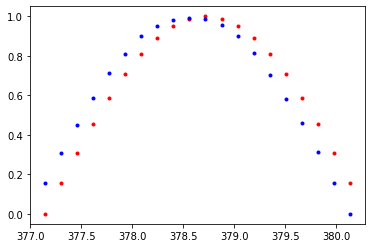

Loss:  9.087116268347017e-06


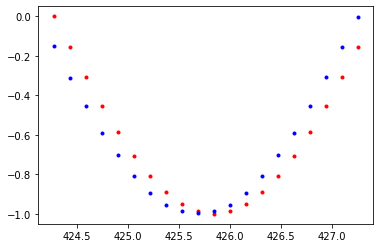

Loss:  2.3881477318354882e-05


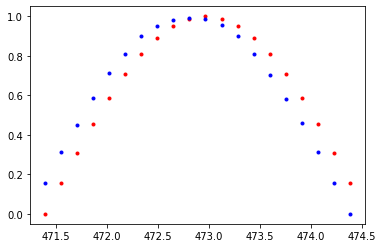

Loss:  7.963297321111895e-06


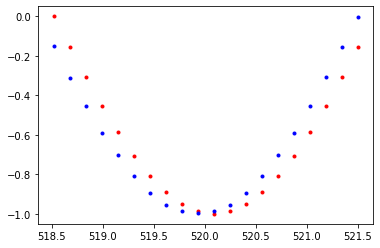

Loss:  2.1345615095924586e-05


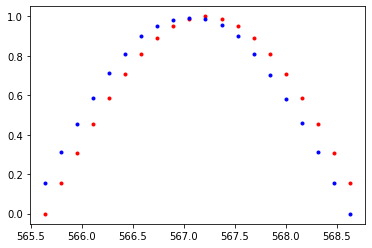

Loss:  7.0572768890997395e-06


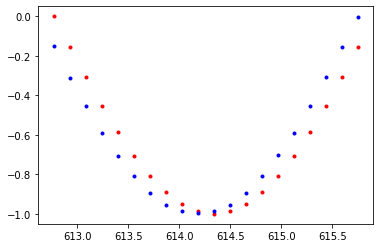

Loss:  1.9274944861535914e-05


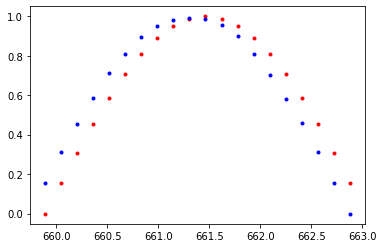

Loss:  6.3341526583826635e-06


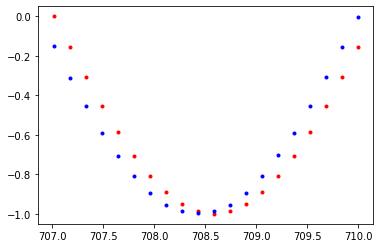

Loss:  1.756163692334667e-05


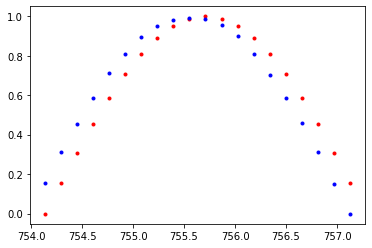

Loss:  5.757909548265161e-06


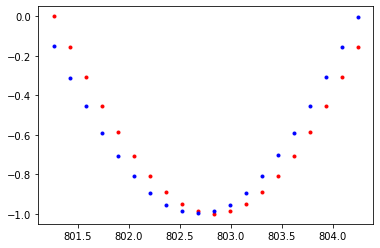

Loss:  1.6120015061460435e-05


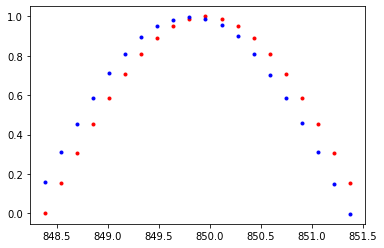

Loss:  5.29773114976706e-06


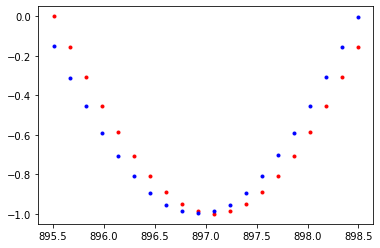

Loss:  1.488573252572678e-05


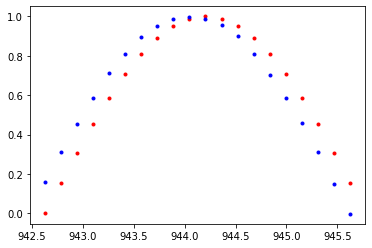

Loss:  4.927640475216322e-06


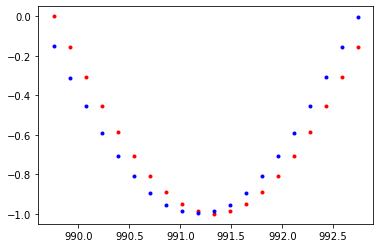

Loss:  1.3812904398946557e-05


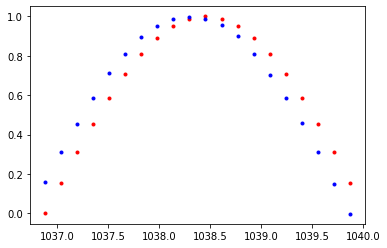

Loss:  4.626163899956737e-06


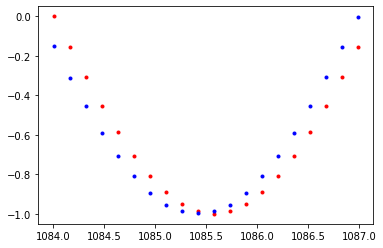

Loss:  1.2872069419245236e-05


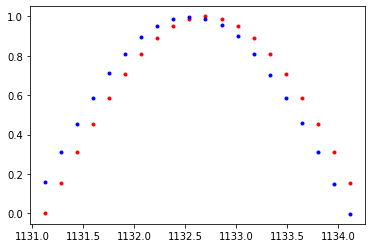

Loss:  4.376622200652491e-06


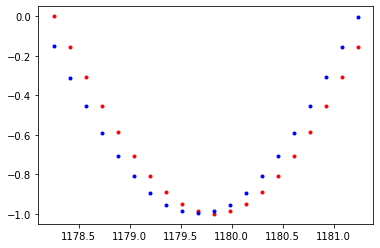

Loss:  1.2037242413498461e-05


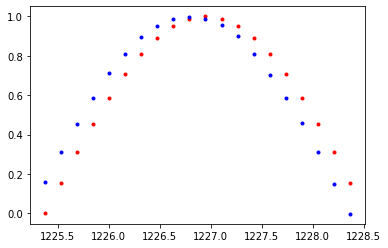

Loss:  4.165598511463031e-06


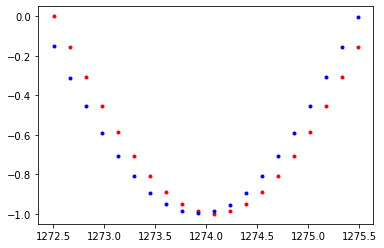

Loss:  1.1293212082819082e-05


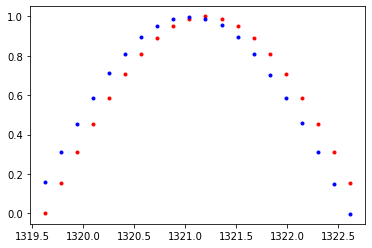

Loss:  3.9832593756727874e-06


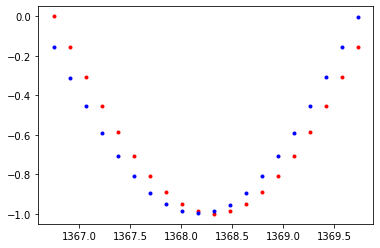

Loss:  1.0626003131619655e-05


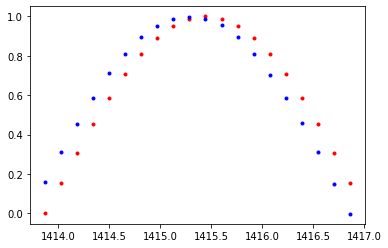

Loss:  3.822142389253713e-06


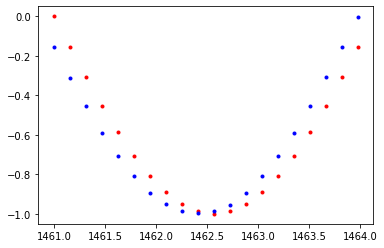

Loss:  1.0023845788964536e-05


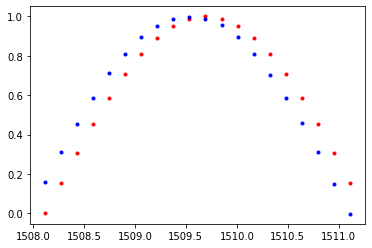

Loss:  3.676997948787175e-06


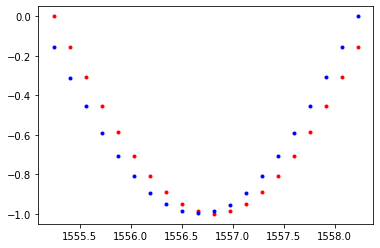

Loss:  9.47954958974151e-06


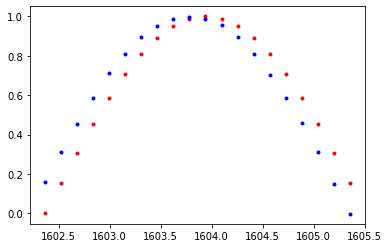

Loss:  3.54309986505541e-06


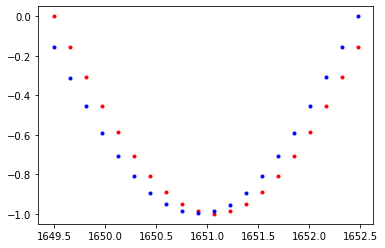

Loss:  8.984578926174436e-06


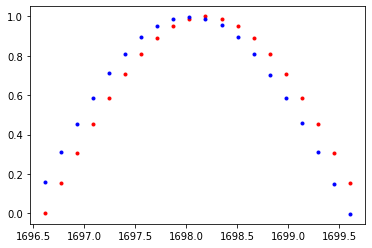

Loss:  3.4188128665846307e-06


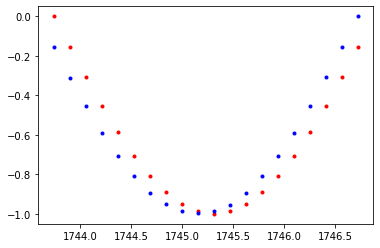

Loss:  8.533116670150775e-06


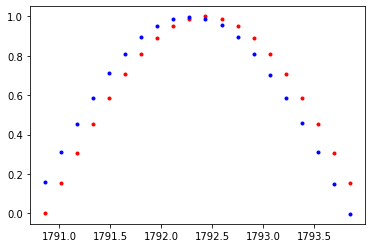

Loss:  3.301139258837793e-06


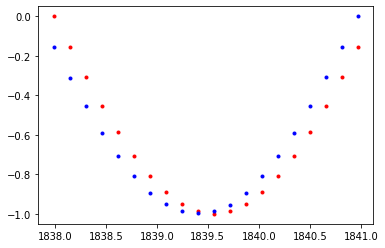

Loss:  8.119761332636699e-06


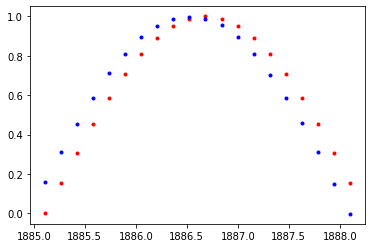

Loss:  3.1894480798655422e-06


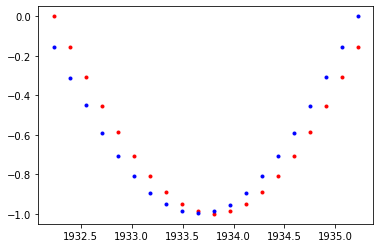

Loss:  7.739499778836034e-06


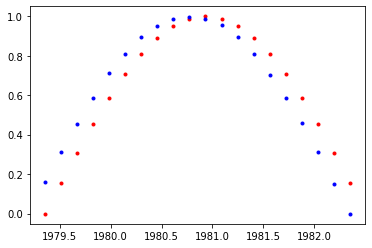

Loss:  3.0824671739537735e-06


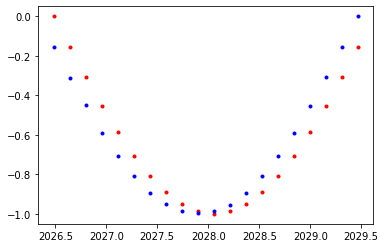

Loss:  7.389058282569749e-06


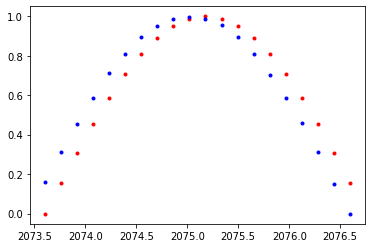

Loss:  2.979586724904948e-06


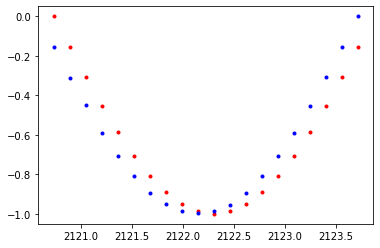

Loss:  7.064267265377566e-06


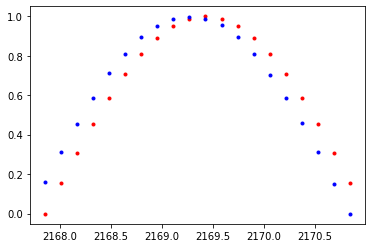

Loss:  2.880831061702338e-06


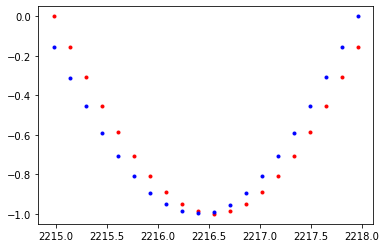

Loss:  6.762813427485526e-06


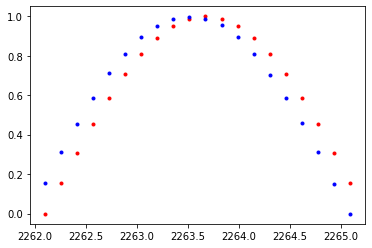

Loss:  2.785615379252704e-06


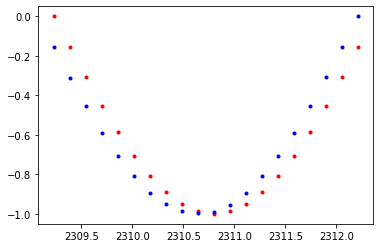

Loss:  6.481839136540657e-06


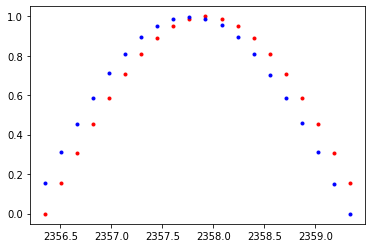

Loss:  2.6936777430819348e-06


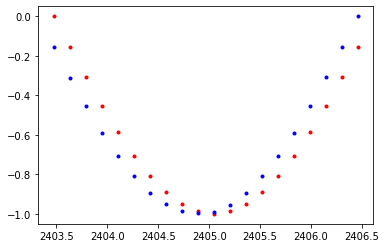

Loss:  6.21957951807417e-06


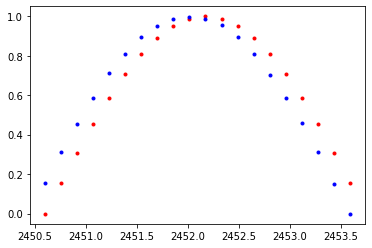

Loss:  2.6074799279740546e-06


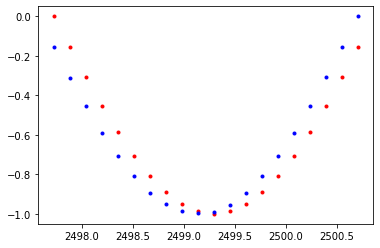

Loss:  5.96282825426897e-06


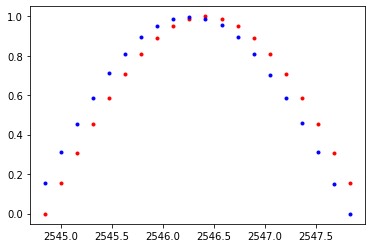

Loss:  2.9327868560358183e-06


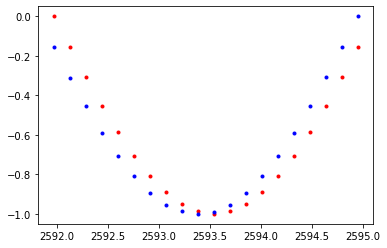

Loss:  5.717329258914106e-06


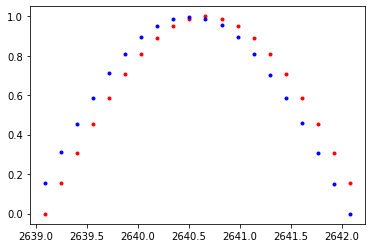

Loss:  2.4627083803352434e-06


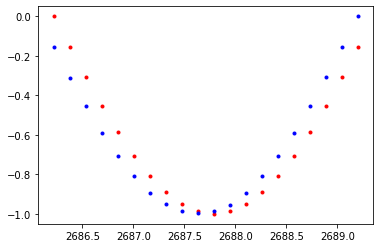

Loss:  5.521474122360814e-06


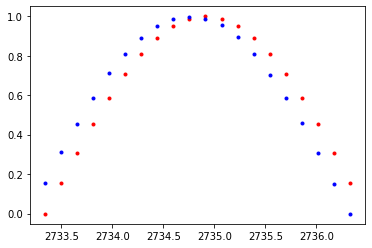

Loss:  2.384853132753051e-06


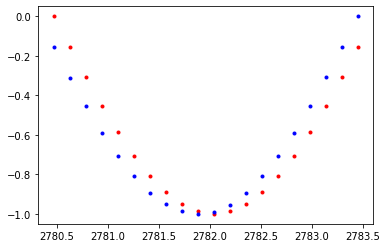

Loss:  5.3141143325774465e-06


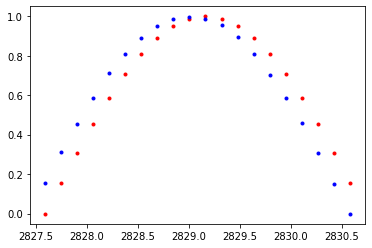

Loss:  2.3191969376057386e-06


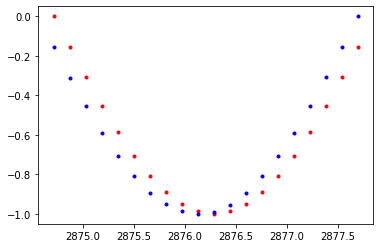

Loss:  5.121929916640511e-06


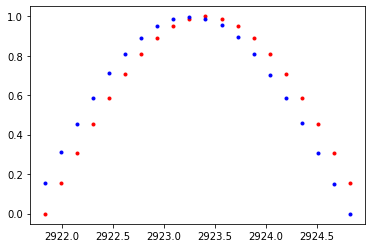

Loss:  2.2547392291016877e-06


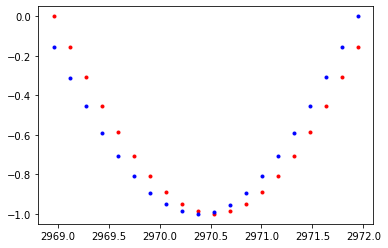

Loss:  4.942612122249557e-06


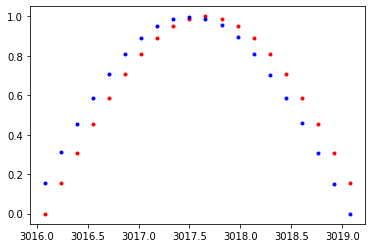

Loss:  2.2008994164934848e-06


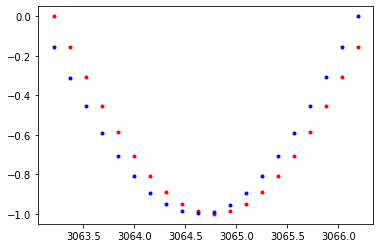

Loss:  4.723297024611384e-06


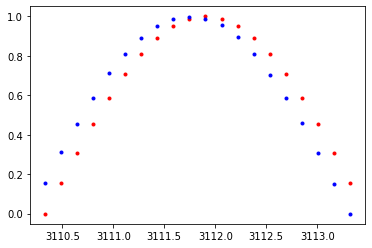

============hidden dimension: 21 ==========
Loss:  0.002238092478364706


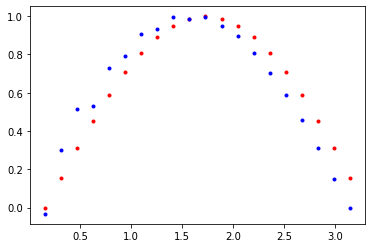

Loss:  2.3764464458508883e-06


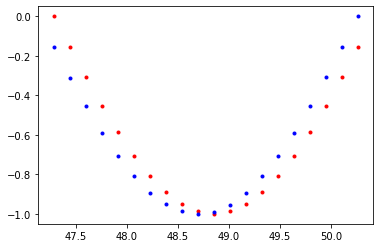

Loss:  4.706735126092099e-06


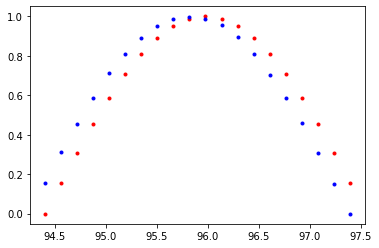

Loss:  2.2287335923465434e-06


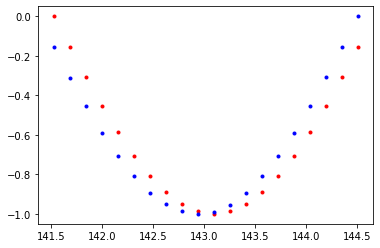

Loss:  4.632830950868083e-06


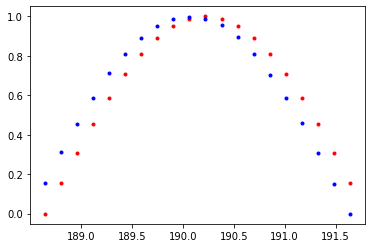

Loss:  2.21011032408569e-06


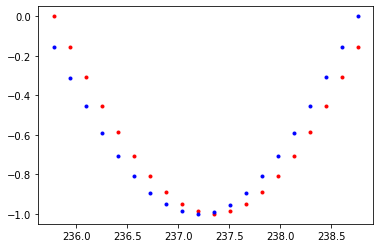

Loss:  4.6006989578017965e-06


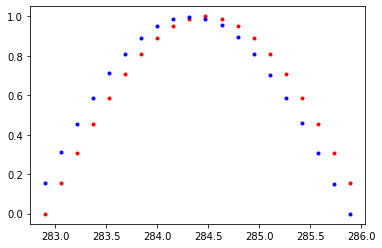

Loss:  2.216416987721459e-06


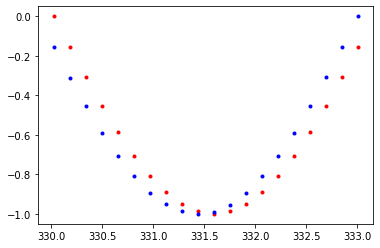

Loss:  4.569894827000098e-06


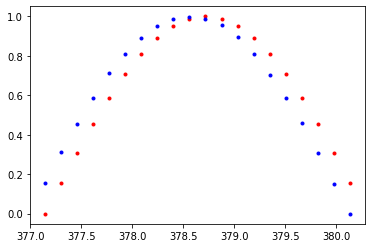

Loss:  2.221587919848389e-06


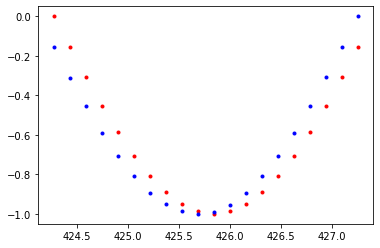

Loss:  4.540710961009609e-06


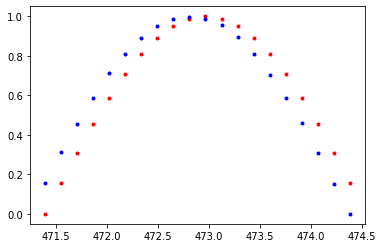

Loss:  2.2230428839975502e-06


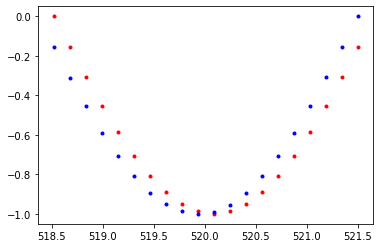

Loss:  4.511226507020183e-06


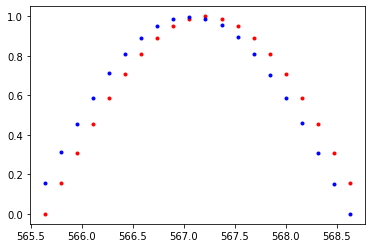

Loss:  2.2241904389375122e-06


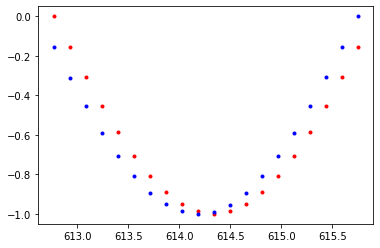

Loss:  4.480985353438882e-06


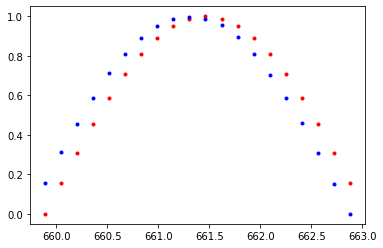

Loss:  2.224511490567238e-06


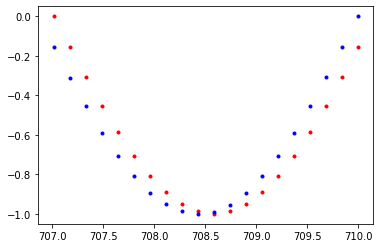

Loss:  4.450401775102364e-06


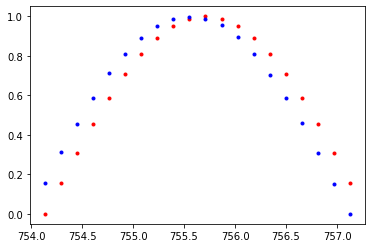

Loss:  2.224801392003428e-06


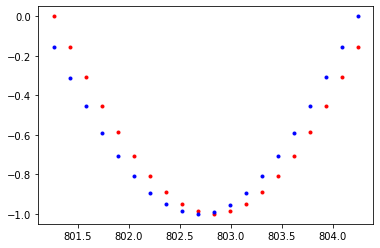

Loss:  4.4190578591951635e-06


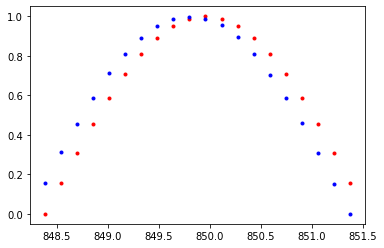

Loss:  2.2245881154958624e-06


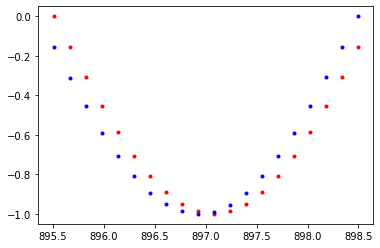

Loss:  4.387505669001257e-06


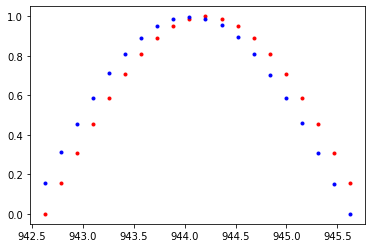

Loss:  2.224149284302257e-06


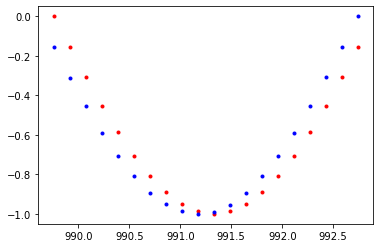

Loss:  4.3556215132412035e-06


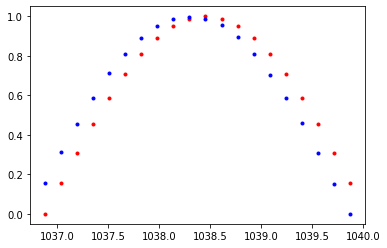

Loss:  2.2236001768760616e-06


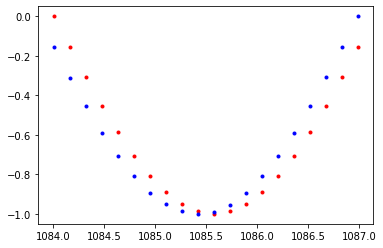

Loss:  4.323407665651757e-06


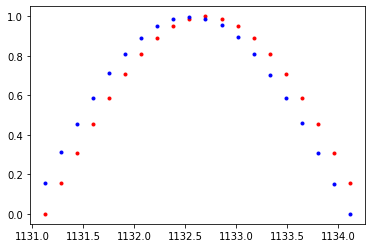

Loss:  2.221952172476449e-06


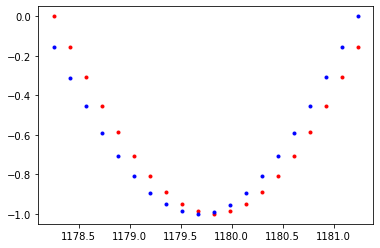

Loss:  4.29094188802992e-06


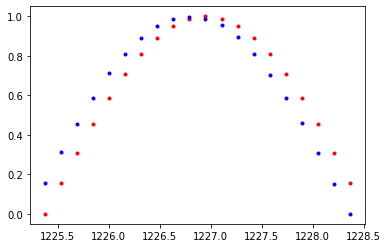

Loss:  2.2201293177204207e-06


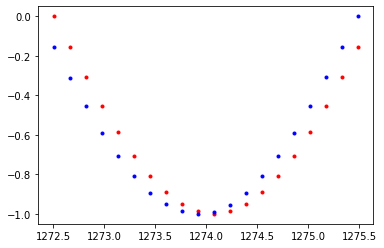

Loss:  4.258625722286524e-06


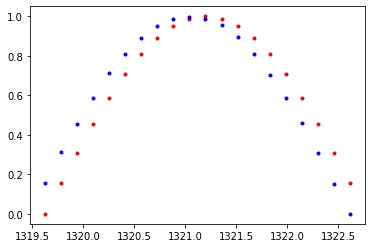

Loss:  2.217649125668686e-06


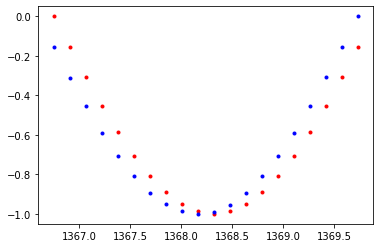

Loss:  4.2267865865142085e-06


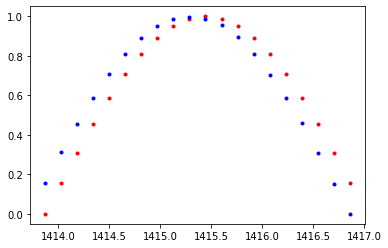

Loss:  2.214511141573894e-06


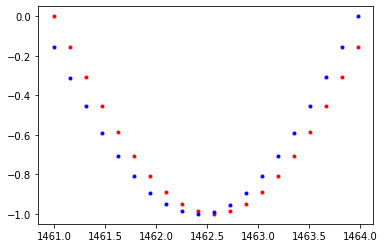

Loss:  4.194569100945955e-06


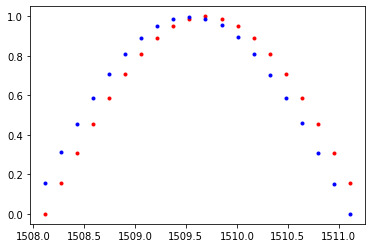

Loss:  2.2104891286289785e-06


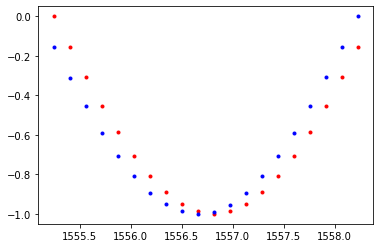

Loss:  4.163010544289136e-06


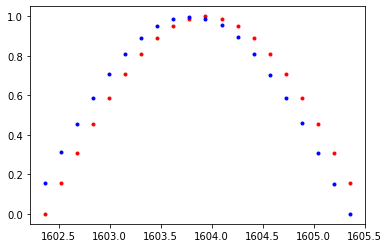

Loss:  2.2060880837670993e-06


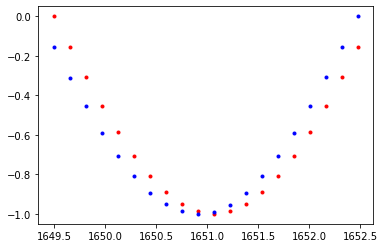

Loss:  4.131654350203462e-06


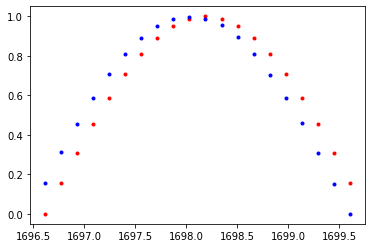

Loss:  2.200825065301615e-06


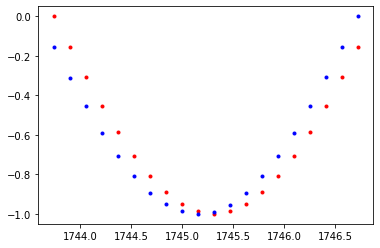

Loss:  4.100734713574639e-06


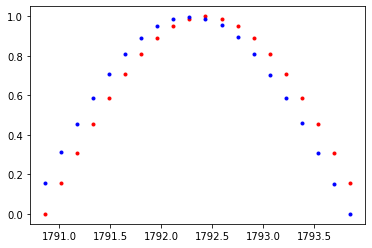

Loss:  2.195030901930295e-06


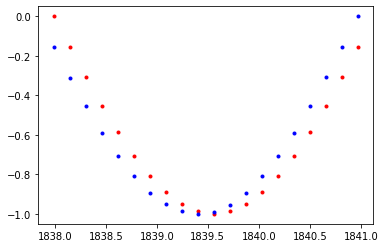

Loss:  4.069786427862709e-06


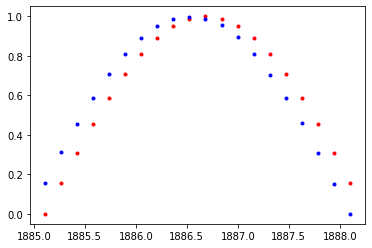

Loss:  2.188534836022882e-06


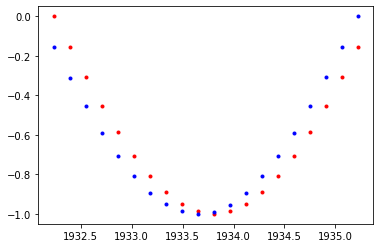

Loss:  4.039868599647889e-06


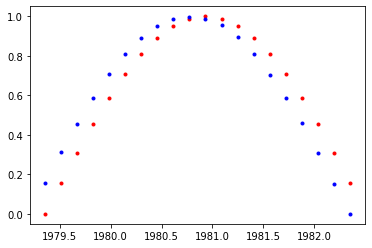

Loss:  2.181219088015496e-06


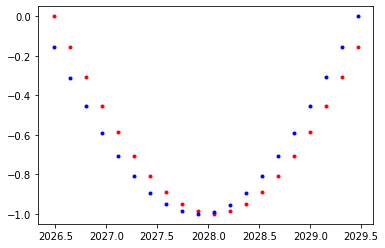

Loss:  4.009917574876454e-06


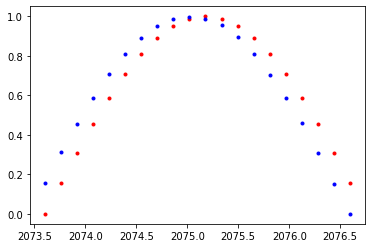

Loss:  2.173235998270684e-06


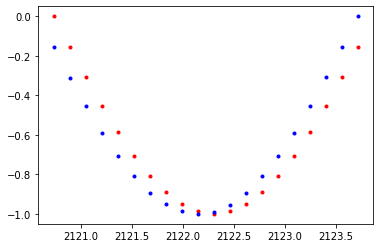

Loss:  3.980348083132412e-06


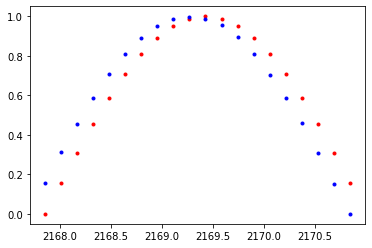

Loss:  2.1644702883349964e-06


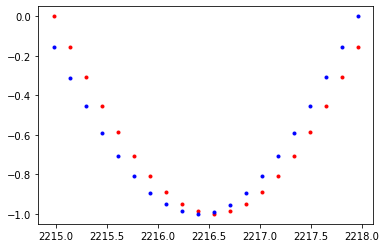

Loss:  3.951433882320998e-06


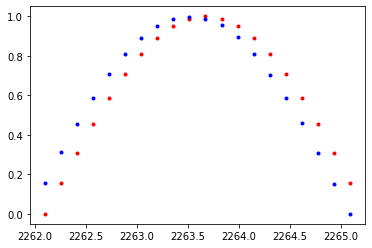

Loss:  2.1553221358772134e-06


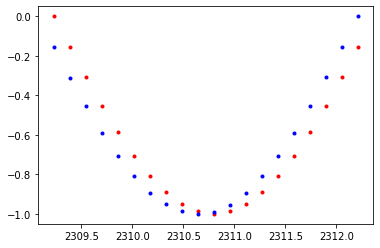

Loss:  3.9228389141499065e-06


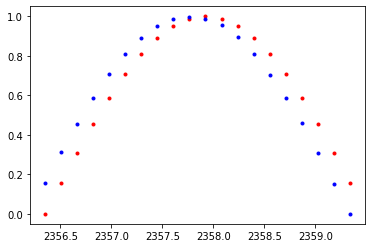

Loss:  2.1453106455737725e-06


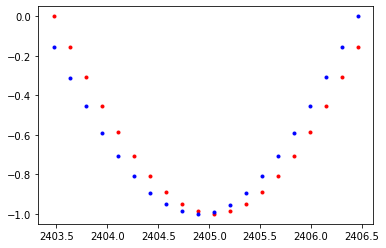

Loss:  3.894611836585682e-06


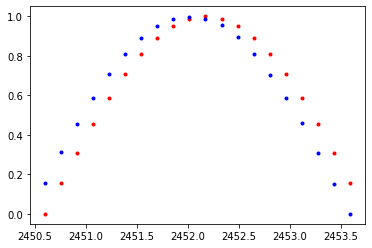

Loss:  2.1347932488424703e-06


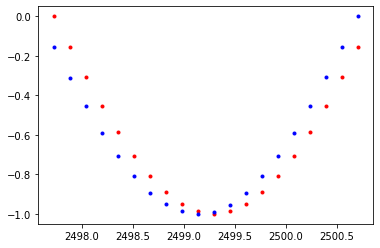

Loss:  3.866633960569743e-06


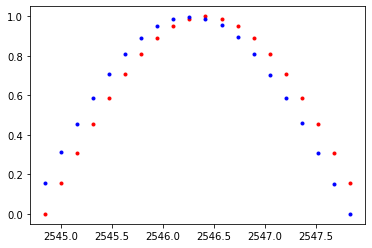

Loss:  2.1234691303106956e-06


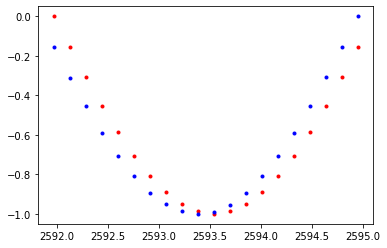

Loss:  3.838662451016717e-06


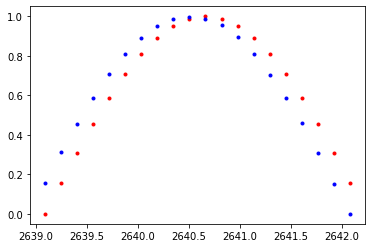

Loss:  2.111573621732532e-06


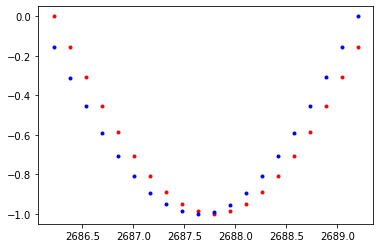

Loss:  3.8118503198347753e-06


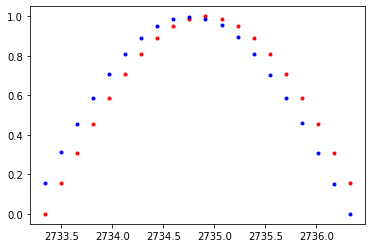

Loss:  2.0989384665881516e-06


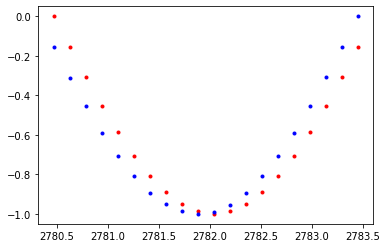

Loss:  3.785052513194387e-06


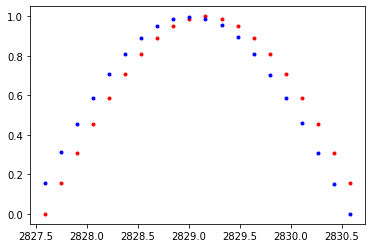

Loss:  2.0858233256149106e-06


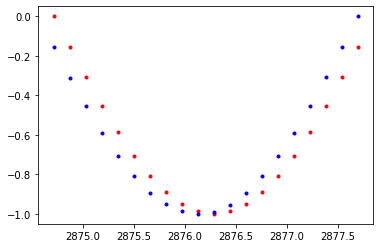

Loss:  3.758781303986325e-06


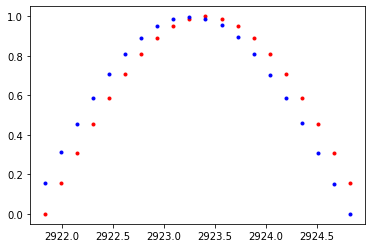

Loss:  2.0722086446767207e-06


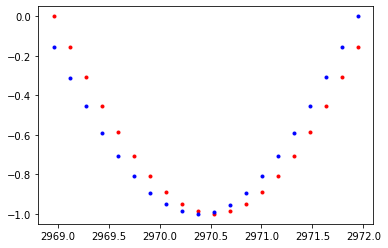

Loss:  3.732562390723615e-06


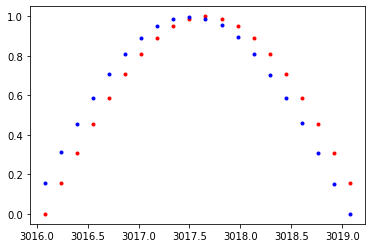

Loss:  2.057610572592239e-06


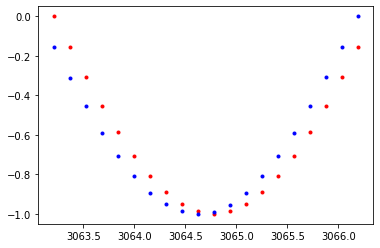

Loss:  3.706845291162608e-06


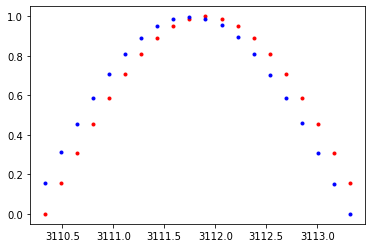

============hidden dimension: 26 ==========
Loss:  0.0030476488173007965


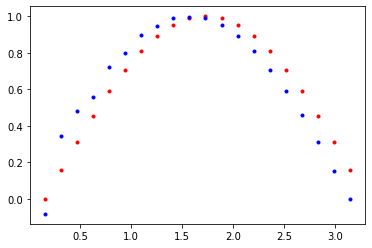

Loss:  2.281346041854704e-06


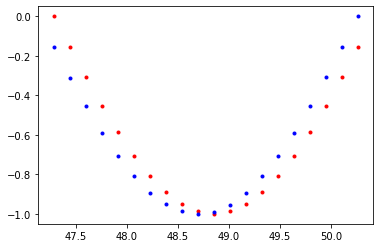

Loss:  3.6538006042974303e-06


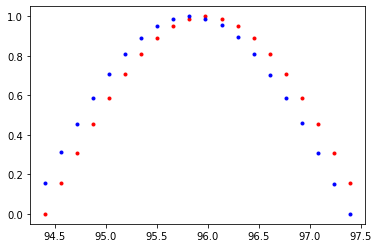

Loss:  2.136690000043018e-06


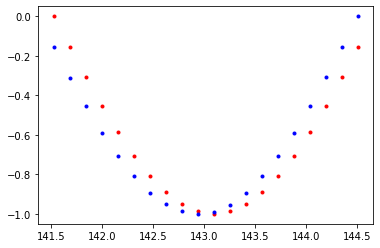

Loss:  3.620305278673186e-06


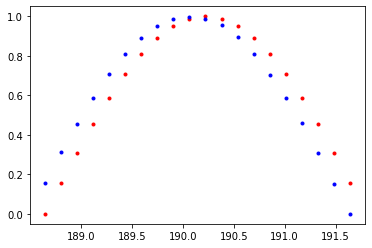

Loss:  2.103322231050697e-06


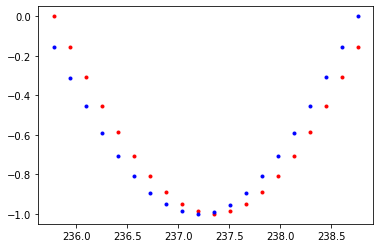

Loss:  3.627305659392732e-06


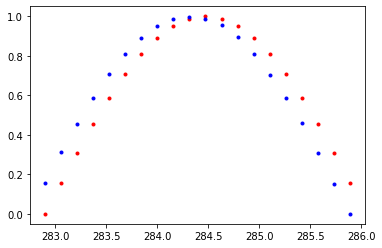

Loss:  2.089347844957956e-06


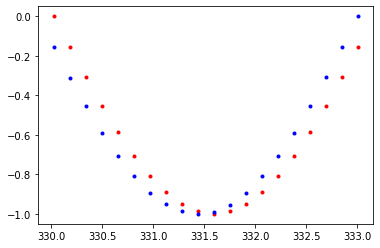

Loss:  3.6282626751926728e-06


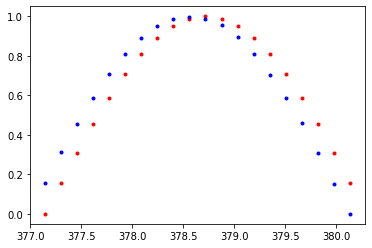

Loss:  2.0793268049601465e-06


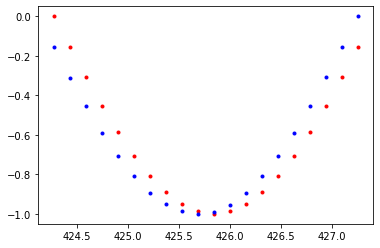

Loss:  3.6311562325863633e-06


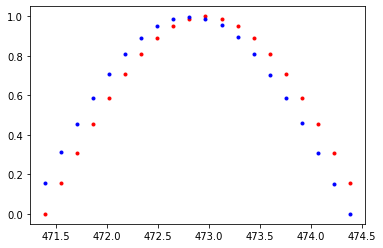

Loss:  2.0704044345620787e-06


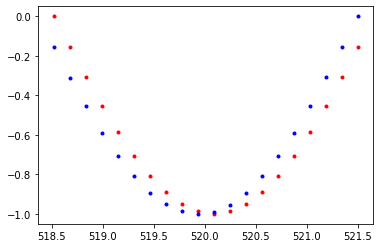

Loss:  3.6342783005238743e-06


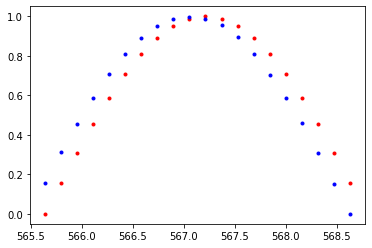

Loss:  2.061927943941555e-06


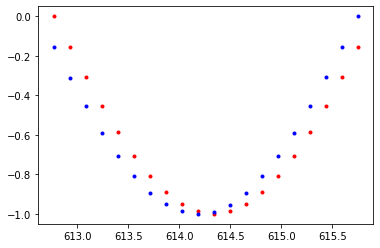

Loss:  3.637741883721901e-06


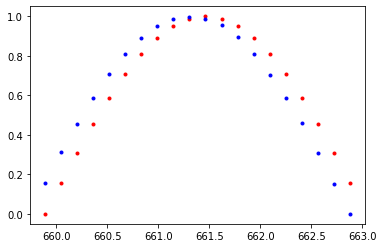

Loss:  2.052790023299167e-06


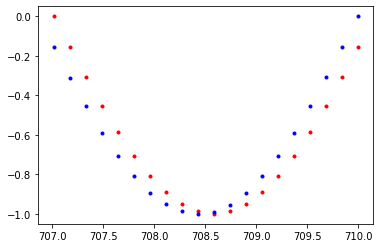

Loss:  3.6409712720342213e-06


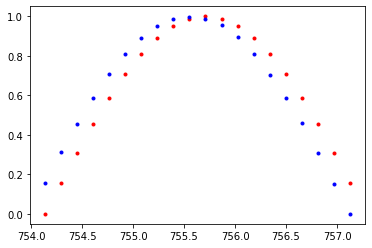

Loss:  2.043449057964608e-06


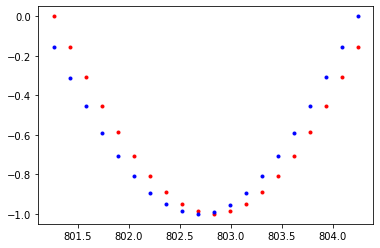

Loss:  3.64340985470335e-06


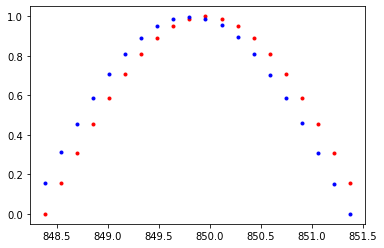

Loss:  2.0332806798251113e-06


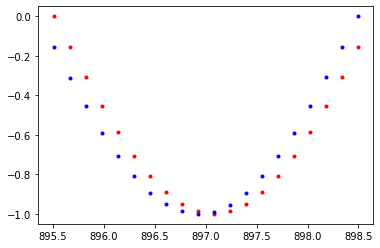

Loss:  3.6453118354984326e-06


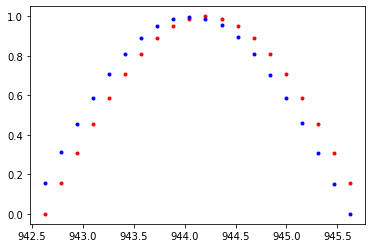

Loss:  2.0225099888193654e-06


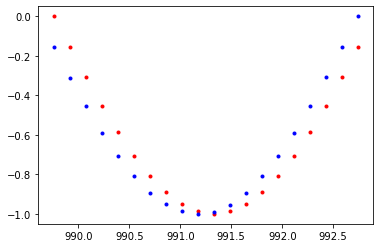

Loss:  3.6469261885940796e-06


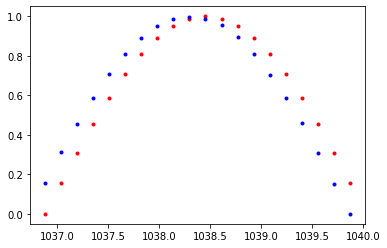

Loss:  2.010900743698585e-06


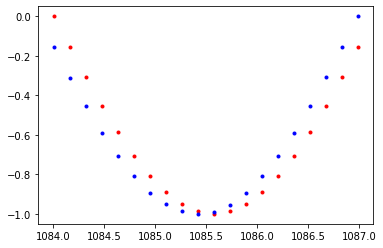

Loss:  3.6480648759606993e-06


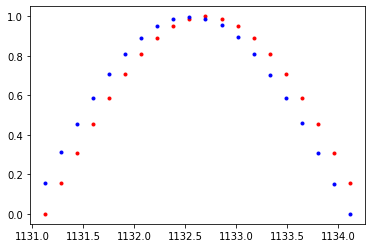

Loss:  1.9983888250862947e-06


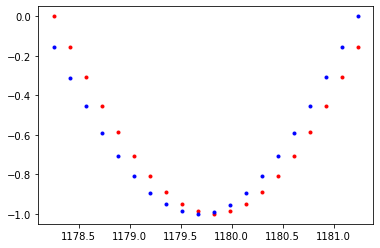

Loss:  3.6483143048826605e-06


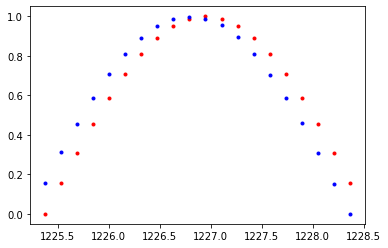

Loss:  1.9850715489155846e-06


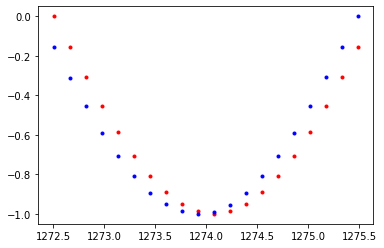

Loss:  3.6478381844062824e-06


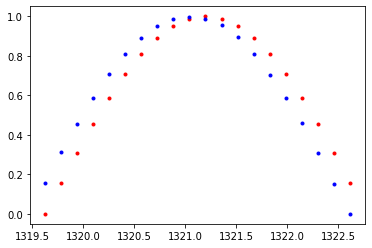

Loss:  1.9711135337274754e-06


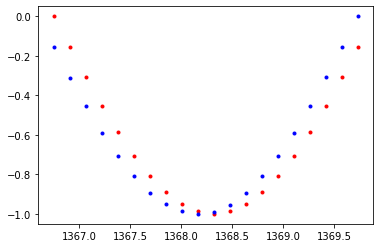

Loss:  3.6472422380029457e-06


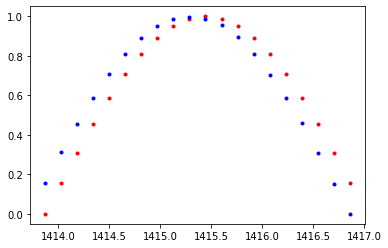

Loss:  1.9563256046239985e-06


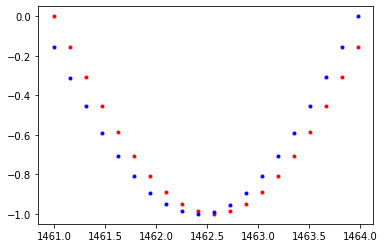

Loss:  3.646205186669249e-06


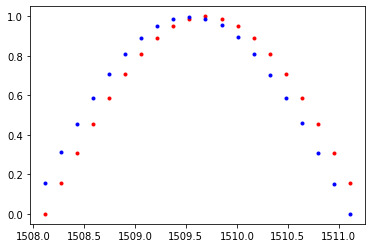

Loss:  1.940837137226481e-06


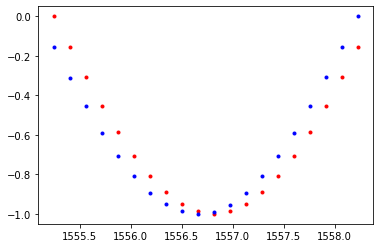

Loss:  3.644804110081168e-06


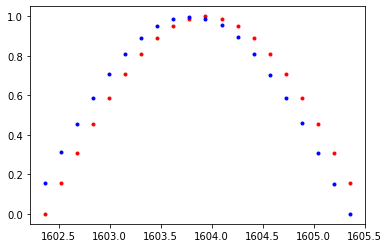

Loss:  1.924679963849485e-06


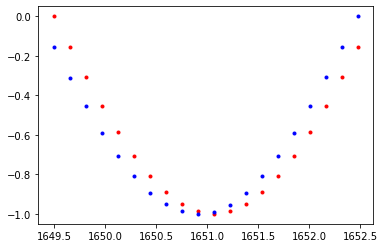

Loss:  3.6430262753128773e-06


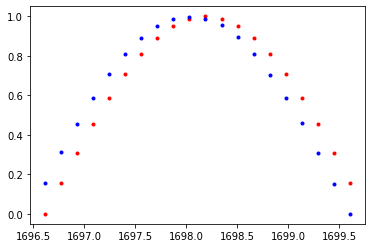

Loss:  1.907734940687078e-06


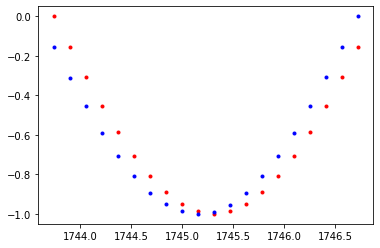

Loss:  3.6410719985724427e-06


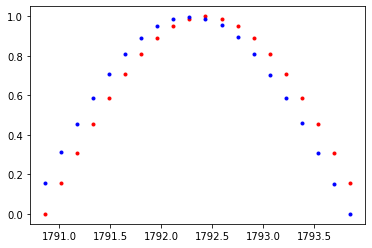

Loss:  1.890290945993911e-06


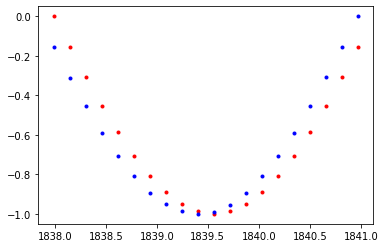

Loss:  3.6389471915754257e-06


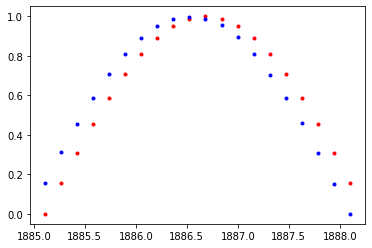

Loss:  1.8722606682786136e-06


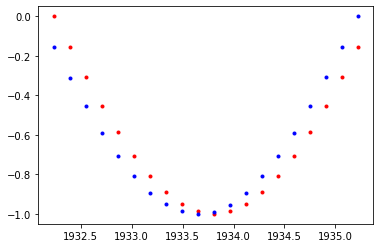

Loss:  3.636808287410531e-06


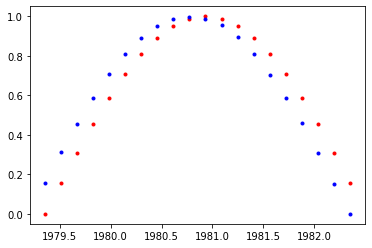

Loss:  1.8536161405791063e-06


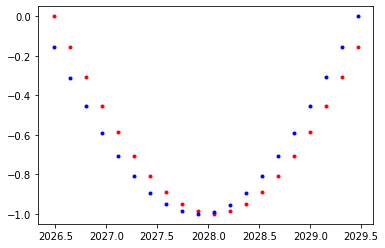

Loss:  3.6347332752484363e-06


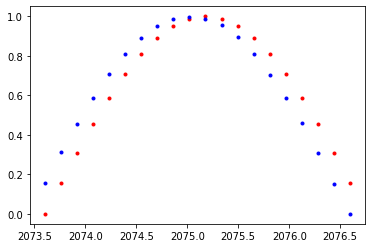

Loss:  1.83459383151785e-06


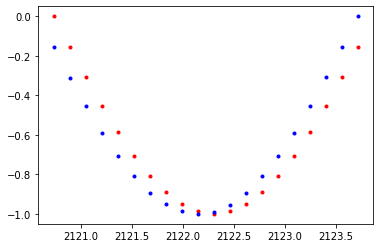

Loss:  3.6323726817499846e-06


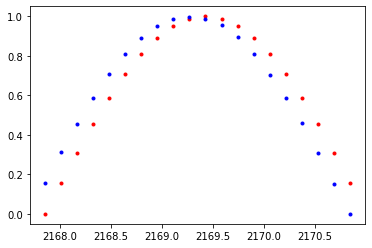

Loss:  1.8149205516237998e-06


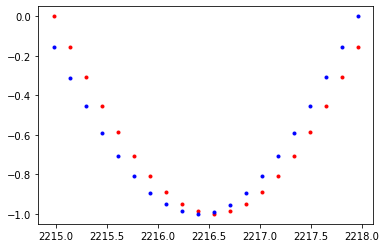

Loss:  3.6302965327195125e-06


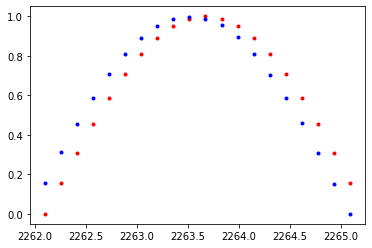

Loss:  1.7949013226825627e-06


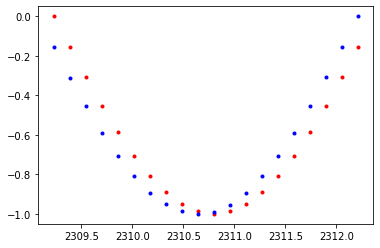

Loss:  3.627995511124027e-06


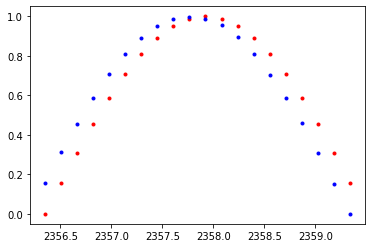

Loss:  1.774566726453486e-06


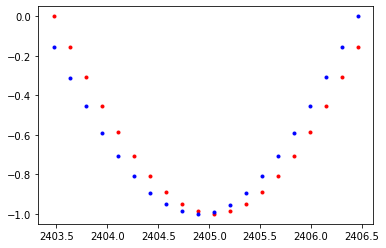

Loss:  3.626017360147671e-06


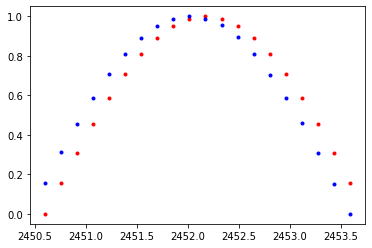

Loss:  1.7539020973345032e-06


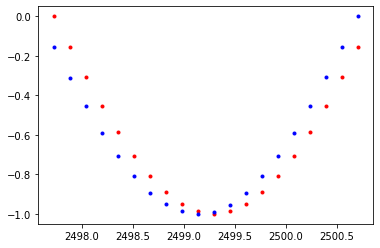

Loss:  3.6240503504814114e-06


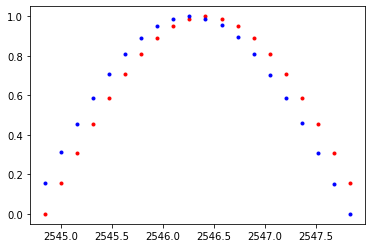

Loss:  1.7328779904346447e-06


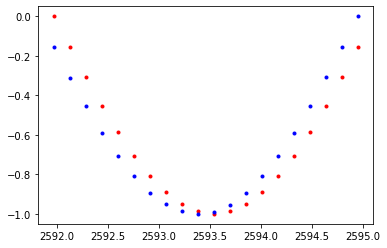

Loss:  3.622198164521251e-06


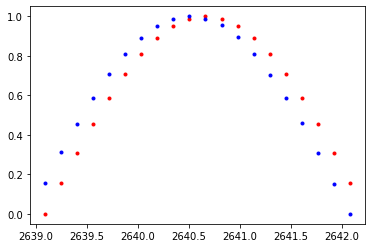

Loss:  1.7113875401264522e-06


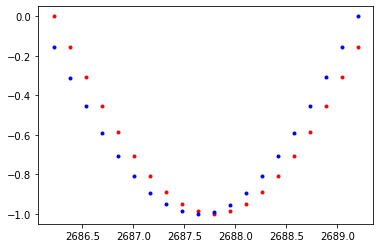

Loss:  3.620450570451794e-06


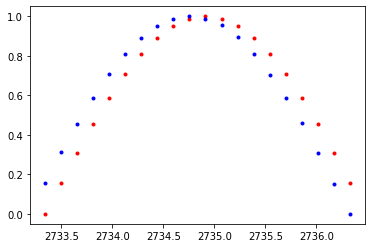

Loss:  1.6899166439543478e-06


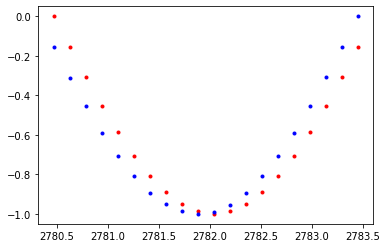

Loss:  3.6187000205245567e-06


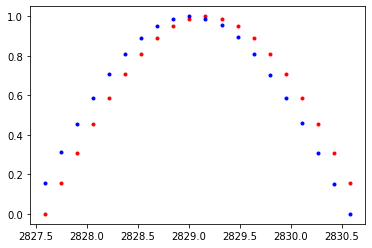

Loss:  1.6681135548424209e-06


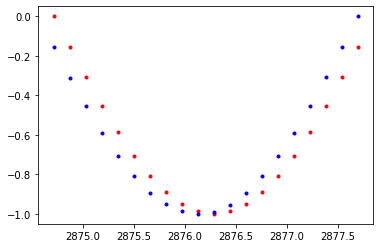

Loss:  3.616929916461231e-06


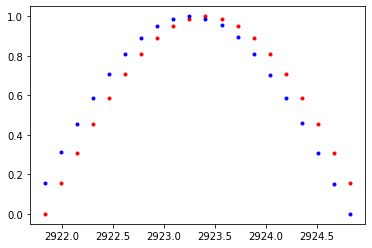

Loss:  1.6460841152365902e-06


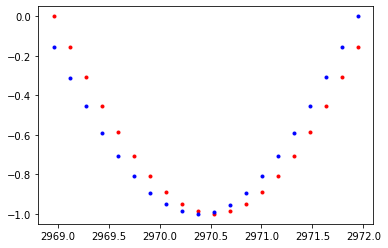

Loss:  3.6153680866846116e-06


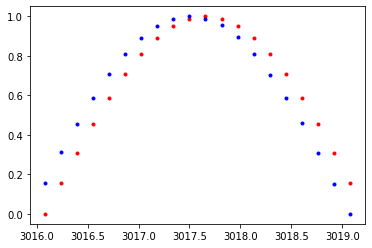

Loss:  1.6240301192738116e-06


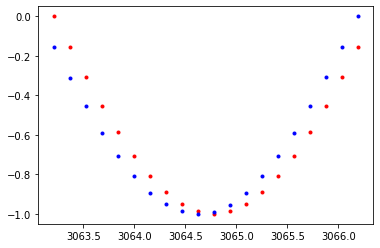

Loss:  3.614072511481936e-06


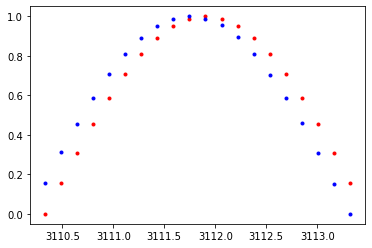

hidden size to loss {1: 0.0009512120741419494, 6: 7.188057497842237e-05, 11: 1.563224031997379e-05, 16: 3.953314717364265e-06, 21: 2.0458337530726567e-06, 26: 1.6063694374679471e-06}


In [19]:
# train the rnn and monitor results
n_steps = 1000
print_every = 15

hiddenDimToLoss = {}

for hid in range(1,31,5):
    hidden_dim = hid
    print(f"============hidden dimension: {hidden_dim} ==========")
    lr = 0.1
    if hid > 5:
        lr = 0.05
    if hid > 15:
        lr = 0.001
    if hid > 20:
        lr = 0.0001
    trained_rnn, loss = train(rnn, n_steps, print_every, lr, True)
    hiddenDimToLoss[hidden_dim] = loss

print(f"hidden size to loss {hiddenDimToLoss}")

In [20]:
print(f"hidden size to loss {hiddenDimToLoss}")

hidden size to loss {1: 0.0009512120741419494, 6: 7.188057497842237e-05, 11: 1.563224031997379e-05, 16: 3.953314717364265e-06, 21: 2.0458337530726567e-06, 26: 1.6063694374679471e-06}


# Observations

Less number of hidden states (1) gives better results than higher number (32) !!!
Why?